Подготовка ноутбука к hadoop cluster вычислениям

## План
1. Подключение к google cloud platform
2. Spark сессия
3. Выгрузка одно месяца (07 2020)
4. Написание запросов для fraud 
5. Написание запросов для не Fraud
6. Создание df для анализа фичей
7. Работа с признаками
8. Описательный анализ df + анализ признаков


In [ ]:
#Общие
import pandas as pd #работа с таблицами и
import numpy as np # работа с массивами
import matplotlib.pyplot as plt # визуализация
import seaborn as sns # визуализация
%matplotlib inline

In [ ]:
#дополнительные
import requests
import math

In [ ]:
# ML unsupervised
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor ## Only available with scikit-learn 0.19 and later
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [ ]:
#Машинное обучение
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB, ComplementNB
from sklearn.model_selection import GridSearchCV # Итеративная подстановка парметров в модели
from sklearn import naive_bayes as nb
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, auc, f1_score, confusion_matrix,precision_score, recall_score, roc_auc_score, roc_curve

In [ ]:
#Google auth
from google.colab import auth
auth.authenticate_user()

### Объявление функций

In [ ]:
## Просмотр данных
def prosmotr(data):
  pd.set_option('display.max_columns', 100) #Размеры таблицы
  pd.set_option('display.max_rows', 100)
  pd.set_option('precision', 2) #Регулируем количество знаков после запятой:
  print('Содержание данных\n', data.head())
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('Размеры данных\n', data.shape)
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('Названия колонок\n', data.columns.to_list())
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('Информация о данных\n')
  print(data.info())
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('Наличие пропусков в данных\n', data.isna().sum())
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('Количество типов в данных\n')
  print(data.dtypes.value_counts())
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  kateg = list(data.select_dtypes(include=['object']).columns) # Делаем список категориальных данных
  print('Категориальные данные\n')
  print(kateg)
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  chislov_float = list(data.select_dtypes(include=['float64'])) #Делаем список числовых данных float
  print('Числове данные float\n')
  print(chislov_float)
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  chislov_int = list(data.select_dtypes(include=['int64'])) #Делаем список числовых данных int
  print('Числове данные int\n')
  print(chislov_int)
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  #print('~~~Основные статистические характеристики данных по каждому числовому признаку (типы int64)~~~\n', data.describe(include=['int64']))
  #print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  #print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Основные статистические характеристики данных по каждому числовому признаку (типы float64)~~~\n', data.describe(include=['float64']))
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

In [ ]:
#функция проходит по колонкам и пробует преобразовать в datetime
def dateTimeConvert(df):
  for i in col_list:
    try:
      df[i] = pd.to_datetime(df[i], infer_datetime_format=True)
      print('for {} convert success'.format(i))
    except: 
      print('cant convert {}'.format(i))
  return df

In [ ]:
# Функция  считает пропуски в данных
def missing_values_table(df):
        # Общее количество пропусков
        mis_val = df.isnull().sum()
        # Процент пропущенных значений
        mis_val_percent = 100 * df.isnull().sum() / len(df)        
        # Создаем таблицу с пропущенными значениями и процентом пропусков
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)        
        # Присваиваем имена колонкам
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Пропущенные значения', 1 : '% от общего числа значений'})        
        # Сортируем по убыванию
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% от общего числа значений', ascending=False).round(1)        
        # Выводим общую информацию
        print ("В вашем датафрейме содержится " + str(df.shape[1]) + " колонок.\n"      
            "Из них " + str(mis_val_table_ren_columns.shape[0]) +
              " колонок имеют пропуски.")        
        # Возвращаем датафрейм с именами колонок, количеством пропусков и процент пропусков
        return mis_val_table_ren_columns

In [ ]:
# Функции метрик бинарной классификации
def value_of_metrics(y_true, y_pred):
    print('Accuracy: ', accuracy_score(y_true, y_pred))
    print('Recall: ', recall_score(y_true, y_pred,average='micro'))
    print('Precision: ', precision_score(y_true, y_pred))  
    print('F1: ', f1_score(y_true, y_pred))
    print('Roc_AUC: ', roc_auc_score(y_true, y_pred))
    print('Confusion Matrix: ')
    print(pd.DataFrame(confusion_matrix(y_true, y_pred)))
    
    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.title('My DataSet')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

##1.Подключение к google cloud platforn

In [ ]:
# Код для подключения к Гугл колабу
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

In [ ]:
!mkdir folderOnColab # Создаём папку подключенную к google cloud platform
!gcsfuse nspk folderOnColab # подклбчаемся к bucket
!ls -ltrh /content/folderOnColab/nspk_transact # Смотрим содержание подключенного бакета

In [ ]:
!ls

adc.json  folderOnColab  sample_data


##2.Spark session

In [ ]:
#ссылки для пакетов pySpark с колаба
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://mirror.klaus-uwe.me/apache/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar -xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

tar: spark-2.4.7-bin-hadoop2.7.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [ ]:
import os
# Задаем окружение
# Указываем переменные окружения для findspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

In [ ]:
# Библиотеки для Spark
import findspark
findspark.init()
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession

# Spark сессия
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler

In [ ]:
# Spark session настройка
spark = SparkSession\
.builder\
.config("spark.dynamicAllocation.enabled", "true")\
.config("spark.executor.cores", 4)\
.config("spark.dynamicAllocation.minExecutors","1")\
.config("spark.dynamicAllocation.maxExecutors","5")\
.getOrCreate()

##3.Выгрузка одного месяца

In [ ]:
# Объединяем части архива для выбранного месяца и распаковываем в системную папку Колаба
!zip -s 0 /content/folderOnColab/_/result_072020.tsv.zip --out f_result_072020.tsv.zip
!unzip f_result_072020.tsv.zip

 copying: result_072020.tsv
Archive:  f_result_072020.tsv.zip
  inflating: result_072020.tsv       
  error:  invalid compressed data to inflate


###3.1 Названия полей транзакций

In [ ]:
#лист всех полей транзакций (признаков)
col_list = ['TRANSACTION_ID', 
            'STATUS',
            'TRANSACTION_TYPE',
            'AMOUNT',
            'CURRENCY',
            'START_TIME',
            'SENDER_BANK_ID',
            'SENDER_USER_ID',
            'SENDER_USER_PAM',
            'RECEIVER_BANK_ID',
            'RECEIVER_USER_ID',
            'RECEIVER_USER_PAM',
            'LAST_MSG_TYPE',
            'A01_CREATED_AT',
            'A01_MSG_STATUS',
            'A01_RESP_CODE',
            'A02_CREATED_AT',
            'A02_MSG_STATUS',
            'A02_RESP_CODE',
            'A21_CREATED_AT',
            'A21_MSG_STATUS',
            'A21_RESP_CODE',
            'A22_CREATED_AT',
            'A22_MSG_STATUS',
            'A22_RESP_CODE',
            'A23_CREATED_AT',
            'A23_MSG_STATUS',
            'A23_RESP_CODE',
            'A24_CREATED_AT',
            'A24_MSG_STATUS',
            'A24_RESP_CODE',
            'C01_CREATED_AT',
            'C01_MSG_STATUS',
            'C01_RESP_CODE',
            'C02_CREATED_AT',
            'C02_MSG_STATUS',
            'C02_RESP_CODE',
            'C03_CREATED_AT',
            'C03_MSG_STATUS',
            'C03_RESP_CODE',
            'C04_CREATED_AT',
            'C04_MSG_STATUS',
            'C04_RESP_CODE',
            'C05_CREATED_AT',
            'C05_MSG_STATUS',
            'C05_RESP_CODE',
            'C06_CREATED_AT',
            'C06_MSG_STATUS',
            'C06_RESP_CODE',
            'C21_CREATED_AT',
            'C21_MSG_STATUS',
            'C21_RESP_CODE',
            'C23_CREATED_AT',
            'C23_MSG_STATUS',
            'C23_RESP_CODE',
            'C22_CREATED_AT',
            'C22_MSG_STATUS',
            'C22_RESP_CODE',
            'C24_CREATED_AT',
            'C24_MSG_STATUS',
            'C24_RESP_CODE']


##4.Написание запросов SQL

###4.1 Fraud list (tech)

In [ ]:
# Лист всех fraud
fraud_list = ['A0211090...',]


###4.2 Spark sql

In [ ]:
# Читаем из директории наор данных  в SparkDataFrame
dec_data = spark.read.csv('/content/result_072020.tsv', sep=r'\t', inferSchema=True, header = False) 
# Выводим первые 10 строк из набора данных
dec_data.show(20)
# Выводим количество строк и столбцов
row_number = dec_data.count()
column_number = len(dec_data.dtypes)
print('Количество строк = {}, количество столбцов = {}'.format(row_number, column_number))

In [ ]:
+--------------------+----+-------+------+---+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----+-------------------+----+------+-------------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-------------------+----+------+-------------------+----+----+-------------------+----+----+-------------------+-----+------+-------------------+----+------+-------------------+----+----+-------------------+----+----+-------------------+----+----+-------------------+----+------+-------------------+----+------+
|                 _c0| _c1|    _c2|   _c3|_c4|                _c5|                 _c6|                 _c7|                 _c8|                 _c9|                _c10|                _c11|_c12|               _c13|_c14|  _c15|               _c16|_c17|_c18|_c19|_c20|_c21|_c22|_c23|_c24|_c25|_c26|_c27|_c28|_c29|_c30|               _c31|_c32|  _c33|               _c34|_c35|_c36|               _c37|_c38|_c39|               _c40| _c41|  _c42|               _c43|_c44|  _c45|               _c46|_c47|_c48|               _c49|_c50|_c51|               _c52|_c53|_c54|               _c55|_c56|  _c57|               _c58|_c59|  _c60|
+--------------------+----+-------+------+---+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----+-------------------+----+------+-------------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-------------------+----+------+-------------------+----+----+-------------------+----+----+-------------------+-----+------+-------------------+----+------+-------------------+----+----+-------------------+----+----+-------------------+----+----+-------------------+----+------+-------------------+----+------+
|B0186000000556010...|RCVD|C2CPush|    \N| \N|2020-07-04 00:00:00|B981300422FD68CFA...|B7019ACA6D29852EA...|                  \N|5376781BC4A4927B7...|1EFF7A6CD826ACC9D...|                  \N| A02|2020-07-04 00:00:00|  OK|I00000|2020-07-04 00:00:00|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|   \N|    \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|    \N|
|B0186000000558020...|ACWP|C2CPush| 34800|RUB|2020-07-04 00:00:00|B981300422FD68CFA...|90618EA6B8272B1EA...|BAB370944CA9F8EEE...|ACFBB4C6863C7CC26...|90618EA6B8272B1EA...|BAB370944CA9F8EEE...| C24|2020-07-04 00:00:00|  OK|I00000|2020-07-04 00:00:00|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-04 00:00:00|  OK|I00000|2020-07-04 00:00:01|  OK| 200|2020-07-04 00:00:00|  OK| 200|2020-07-04 00:00:01|   OK|I00000|2020-07-04 00:00:02|  OK|I00000|2020-07-04 00:00:02|  OK| 200|2020-07-04 00:00:02|  OK| 200|2020-07-04 00:00:02|  OK| 200|2020-07-04 00:00:03|  OK|I00000|2020-07-04 00:00:03|  OK|I00000|
|A0186000001723010...|RJCT|C2CPush| 10000|RUB|2020-07-04 00:00:01|B981300422FD68CFA...|6287A6D52D800E872...|ACF9FF570784CC9ED...|ACFBB4C6863C7CC26...|B518566E3D60FC8F0...|                  \N| C02|2020-07-04 00:00:01|  OK|I00000|2020-07-04 00:00:01|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-04 00:00:01|  OK|I00000|2020-07-04 00:00:02|  OK| 200|2020-07-04 00:00:01|  OK| 200|2020-07-04 00:00:02|ERROR|I05043|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|    \N|
|B0186000001717010...|RCVD|C2CPush|    \N| \N|2020-07-04 00:00:01|B981300422FD68CFA...|6287A6D52D800E872...|                  \N|5376781BC4A4927B7...|B518566E3D60FC8F0...|                  \N| A02|2020-07-04 00:00:01|  OK|I00000|2020-07-04 00:00:01|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|   \N|    \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|    \N|
|A0186000002191010...|RJCT|C2CPush|    \N| \N|2020-07-04 00:00:02|F9923AF9BCB77DAC1...|2A5221FA09A9128E6...|                  \N|5376781BC4A4927B7...|7779E788EFE118D01...|                  \N| A02|2020-07-04 00:00:02|  OK|I00000|2020-07-04 00:00:02|  OK| 202|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|   \N|    \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|    \N|
|A0186000004040010...|RJCT|C2CPush| 10000|RUB|2020-07-04 00:00:04|B981300422FD68CFA...|6287A6D52D800E872...|ACF9FF570784CC9ED...|ACFBB4C6863C7CC26...|B518566E3D60FC8F0...|                  \N| C02|2020-07-04 00:00:04|  OK|I00000|2020-07-04 00:00:04|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-04 00:00:04|  OK|I00000|2020-07-04 00:00:04|  OK| 200|2020-07-04 00:00:04|  OK| 200|2020-07-04 00:00:04|ERROR|I05043|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|    \N|
|B0186000004032010...|RCVD|C2CPush|    \N| \N|2020-07-04 00:00:04|B981300422FD68CFA...|6287A6D52D800E872...|                  \N|5376781BC4A4927B7...|B518566E3D60FC8F0...|                  \N| A02|2020-07-04 00:00:04|  OK|I00000|2020-07-04 00:00:04|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|   \N|    \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|    \N|
|B0186000006090010...|RCVD|C2CPush|    \N| \N|2020-07-04 00:00:06|B981300422FD68CFA...|BC901F657D5EE62C2...|                  \N|5376781BC4A4927B7...|BC901F657D5EE62C2...|                  \N| A02|2020-07-04 00:00:06|  OK|I00000|2020-07-04 00:00:06|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|   \N|    \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|    \N|
|B0186000006820020...|RCVD|C2CPush|    \N| \N|2020-07-04 00:00:06|B981300422FD68CFA...|3EE0D629FC530475B...|                  \N|5376781BC4A4927B7...|695AB005B78CEAD6E...|                  \N| A02|2020-07-04 00:00:06|  OK|I00000|2020-07-04 00:00:06|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|   \N|    \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|    \N|
|B0186000008138010...|RCVD|C2CPush|    \N| \N|2020-07-04 00:00:08|B981300422FD68CFA...|66A14D1E875376AF8...|                  \N|5376781BC4A4927B7...|16085DB4294336753...|                  \N| A02|2020-07-04 00:00:08|  OK|I00000|2020-07-04 00:00:08|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|   \N|    \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|    \N|
|B0186000008758020...|RJCT|C2CPush|    \N| \N|2020-07-04 00:00:08|21D7BFD812C9B89F5...|D98B98884334EB685...|                  \N|5376781BC4A4927B7...|2114BBECE4276C2AF...|                  \N| A02|2020-07-04 00:00:08|  OK|I00000|2020-07-04 00:00:08|  OK| 201|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|   \N|    \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|    \N|
|B0186000010158010...|ACWP|C2CPush|200000|RUB|2020-07-04 00:00:10|C13B1053D5C012F2F...|1936ADB3FE33F2D74...|29EA9E8B78D225E5C...|B981300422FD68CFA...|72FCBDBACB714A1C4...|F0BE4282C8809E800...| C22|2020-07-04 00:00:10|  OK|I00000|2020-07-04 00:00:10|  OK| 202|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-04 00:00:26|  OK|I00000|2020-07-04 00:00:26|  OK| 202|2020-07-04 00:00:26|  OK| 200|2020-07-04 00:00:26|   OK|I00000|2020-07-04 00:01:41|  OK|I00000|2020-07-04 00:01:41|  OK| 202|2020-07-04 00:01:42|  OK| 202|2020-07-04 00:01:42|  OK| 200|2020-07-04 00:01:42|  OK|I00000|2020-07-04 00:01:42|  OK|I00000|
|B0186000010374010...|RCVD|C2CPush|    \N| \N|2020-07-04 00:00:10|B981300422FD68CFA...|6424BC07D0E8A8006...|                  \N|21D7BFD812C9B89F5...|48ED7E903F5A7A84D...|                  \N| A02|2020-07-04 00:00:10|  OK|I00000|2020-07-04 00:00:10|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|   \N|    \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|    \N|
|A0186000011140020...|RJCT|C2CPush| 10000|RUB|2020-07-04 00:00:11|B981300422FD68CFA...|7F37AD97E47A53B3F...|92C74BB7B0378FE66...|ACFBB4C6863C7CC26...|09CC98FDC2F20F488...|                  \N| C02|2020-07-04 00:00:11|  OK|I00000|2020-07-04 00:00:11|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-04 00:00:11|  OK|I00000|2020-07-04 00:00:12|  OK| 200|2020-07-04 00:00:11|  OK| 200|2020-07-04 00:00:11|ERROR|I05043|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|    \N|
|A0186000011153030...|RCVD|C2CPush|    \N| \N|2020-07-04 00:00:11|00BB5107311C264AF...|531C4C71ED9A317BD...|                  \N|00BB5107311C264AF...|531C4C71ED9A317BD...|                  \N| A02|2020-07-04 00:00:11|  OK|I00000|2020-07-04 00:00:11|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|   \N|    \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|    \N|
|A0186000011207020...|RCVD|C2CPush|    \N| \N|2020-07-04 00:00:11|64281C17DA3E44CDA...|00F1B74EE73DBD939...|                  \N|5376781BC4A4927B7...|00F1B74EE73DBD939...|                  \N| A02|2020-07-04 00:00:11|  OK|I00000|2020-07-04 00:00:11|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|   \N|    \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|    \N|
|B0186000011049010...|RCVD|C2CPush|    \N| \N|2020-07-04 00:00:11|B981300422FD68CFA...|7FB7E8F2F9E5A4C50...|                  \N|5376781BC4A4927B7...|541271F09B3068628...|                  \N| A02|2020-07-04 00:00:11|  OK|I00000|2020-07-04 00:00:11|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|   \N|    \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|    \N|
|B0186000011136010...|RCVD|C2CPush|    \N| \N|2020-07-04 00:00:11|B981300422FD68CFA...|7F37AD97E47A53B3F...|                  \N|5376781BC4A4927B7...|09CC98FDC2F20F488...|                  \N| A02|2020-07-04 00:00:11|  OK|I00000|2020-07-04 00:00:11|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|   \N|    \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|    \N|
|B0186000011678020...|RJCT|C2CPush|    \N| \N|2020-07-04 00:00:11|21D7BFD812C9B89F5...|FC092AEA69BF6E748...|                  \N|5376781BC4A4927B7...|56D002F0E7AB208AB...|                  \N| A02|2020-07-04 00:00:11|  OK|I00000|2020-07-04 00:00:11|  OK| 201|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|   \N|    \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|    \N|
|B0186000012220010...|RCVD|C2CPush|    \N| \N|2020-07-04 00:00:12|B981300422FD68CFA...|4D6F8494998D6980C...|                  \N|5376781BC4A4927B7...|2F8EF16D3B96D52CF...|                  \N| A02|2020-07-04 00:00:12|  OK|I00000|2020-07-04 00:00:12|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|   \N|    \N|                 \N|  \N|    \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|  \N|                 \N|  \N|    \N|                 \N|  \N|    \N|
+--------------------+----+-------+------+---+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----+-------------------+----+------+-------------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-------------------+----+------+-------------------+----+----+-------------------+----+----+-------------------+-----+------+-------------------+----+------+-------------------+----+----+-------------------+----+----+-------------------+----+----+-------------------+----+------+-------------------+----+------+

###4.3 Fraud SQL запрос и перенос в Pandas DF

In [ ]:
# мошеннические операции
%%time
dec_data.registerTempTable("dec_data")
#SQL december data with sum
fraud_072020 = spark.sql("SELECT * \
                          FROM dec_data \
                          WHERE _c0 IN {}".format(tuple(fraud_list)))# в качестве аргумента используем SQL запрос
fraud_072020.show(20)         

In [ ]:
+--------------------+----+-------+-------+---+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----+-------------------+----+------+-------------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-------------------+----+------+-------------------+----+----+-------------------+----+----+-------------------+----+------+-------------------+----+------+-------------------+----+----+-------------------+----+----+-------------------+----+----+-------------------+----+------+-------------------+----+------+
|                 _c0| _c1|    _c2|    _c3|_c4|                _c5|                 _c6|                 _c7|                 _c8|                 _c9|                _c10|                _c11|_c12|               _c13|_c14|  _c15|               _c16|_c17|_c18|_c19|_c20|_c21|_c22|_c23|_c24|_c25|_c26|_c27|_c28|_c29|_c30|               _c31|_c32|  _c33|               _c34|_c35|_c36|               _c37|_c38|_c39|               _c40|_c41|  _c42|               _c43|_c44|  _c45|               _c46|_c47|_c48|               _c49|_c50|_c51|               _c52|_c53|_c54|               _c55|_c56|  _c57|               _c58|_c59|  _c60|
+--------------------+----+-------+-------+---+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----+-------------------+----+------+-------------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-------------------+----+------+-------------------+----+----+-------------------+----+----+-------------------+----+------+-------------------+----+------+-------------------+----+----+-------------------+----+----+-------------------+----+----+-------------------+----+------+-------------------+----+------+
|B0201083324810060...|ACWP|C2CPush|   1000|RUB|2020-07-19 08:33:24|614C25CEFAFF6B74E...|A1BA3FCE8BA1DA2A8...|5C16B6F3DCBB66B87...|5F05A830BAD25C90C...|4813E60B013086927...|9F92F075C06256A69...| C22|2020-07-19 08:33:24|  OK|I00000|2020-07-19 08:33:24|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 08:33:30|  OK|I00000|2020-07-19 08:33:31|  OK| 200|2020-07-19 08:33:30|  OK| 200|2020-07-19 08:33:31|  OK|I00000|2020-07-19 08:36:11|  OK|I00000|2020-07-19 08:36:11|  OK| 200|2020-07-19 08:36:11|  OK| 200|2020-07-19 08:36:11|  OK| 200|2020-07-19 08:36:12|  OK|I00000|2020-07-19 08:36:12|  OK|I00000|
|A0201084920994050...|ACWP|C2CPush|1100000|RUB|2020-07-19 08:49:21|614C25CEFAFF6B74E...|A1BA3FCE8BA1DA2A8...|5C16B6F3DCBB66B87...|00BB5107311C264AF...|43D83A1987E80869A...|222DCC9D9C64F13C3...| C22|2020-07-19 08:49:20|  OK|I00000|2020-07-19 08:49:21|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 08:49:26|  OK|I00000|2020-07-19 08:49:27|  OK| 200|2020-07-19 08:49:26|  OK| 200|2020-07-19 08:49:27|  OK|I00000|2020-07-19 08:49:45|  OK|I00000|2020-07-19 08:49:45|  OK| 200|2020-07-19 08:49:46|  OK| 200|2020-07-19 08:49:46|  OK| 200|2020-07-19 08:49:46|  OK|I00000|2020-07-19 08:49:46|  OK|I00000|
|B0201090029720050...|ACWP|C2CPush|3000000|RUB|2020-07-19 09:00:29|614C25CEFAFF6B74E...|A1BA3FCE8BA1DA2A8...|5C16B6F3DCBB66B87...|00BB5107311C264AF...|43D83A1987E80869A...|222DCC9D9C64F13C3...| C22|2020-07-19 09:00:29|  OK|I00000|2020-07-19 09:00:29|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 09:00:34|  OK|I00000|2020-07-19 09:00:35|  OK| 200|2020-07-19 09:00:34|  OK| 200|2020-07-19 09:00:35|  OK|I00000|2020-07-19 09:01:06|  OK|I00000|2020-07-19 09:01:06|  OK| 200|2020-07-19 09:01:07|  OK| 200|2020-07-19 09:01:07|  OK| 200|2020-07-19 09:01:07|  OK|I00000|2020-07-19 09:01:07|  OK|I00000|
|B0201090137556070...|ACWP|C2CPush|3000000|RUB|2020-07-19 09:01:37|614C25CEFAFF6B74E...|A1BA3FCE8BA1DA2A8...|5C16B6F3DCBB66B87...|5F05A830BAD25C90C...|4813E60B013086927...|9F92F075C06256A69...| C22|2020-07-19 09:01:37|  OK|I00000|2020-07-19 09:01:37|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 09:01:43|  OK|I00000|2020-07-19 09:01:44|  OK| 200|2020-07-19 09:01:43|  OK| 200|2020-07-19 09:01:44|  OK|I00000|2020-07-19 09:02:12|  OK|I00000|2020-07-19 09:02:12|  OK| 200|2020-07-19 09:02:12|  OK| 200|2020-07-19 09:02:12|  OK| 200|2020-07-19 09:02:13|  OK|I00000|2020-07-19 09:02:13|  OK|I00000|
|A0201090618516020...|ACWP|C2CPush|3000000|RUB|2020-07-19 09:06:18|614C25CEFAFF6B74E...|A1BA3FCE8BA1DA2A8...|5C16B6F3DCBB66B87...|5F05A830BAD25C90C...|4813E60B013086927...|9F92F075C06256A69...| C22|2020-07-19 09:06:18|  OK|I00000|2020-07-19 09:06:18|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 09:06:22|  OK|I00000|2020-07-19 09:06:23|  OK| 200|2020-07-19 09:06:22|  OK| 200|2020-07-19 09:06:23|  OK|I00000|2020-07-19 09:06:55|  OK|I00000|2020-07-19 09:06:55|  OK| 200|2020-07-19 09:06:56|  OK| 200|2020-07-19 09:06:56|  OK| 200|2020-07-19 09:06:56|  OK|I00000|2020-07-19 09:06:56|  OK|I00000|
|A0201091236715020...|ACWP|C2CPush|3000000|RUB|2020-07-19 09:12:36|614C25CEFAFF6B74E...|A1BA3FCE8BA1DA2A8...|5C16B6F3DCBB66B87...|5F05A830BAD25C90C...|FC435974387AA8CF5...|5862A95E075280731...| C22|2020-07-19 09:12:36|  OK|I00000|2020-07-19 09:12:36|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 09:12:44|  OK|I00000|2020-07-19 09:12:45|  OK| 200|2020-07-19 09:12:44|  OK| 200|2020-07-19 09:12:45|  OK|I00000|2020-07-19 09:13:10|  OK|I00000|2020-07-19 09:13:10|  OK| 200|2020-07-19 09:13:11|  OK| 200|2020-07-19 09:13:11|  OK| 200|2020-07-19 09:13:11|  OK|I00000|2020-07-19 09:13:11|  OK|I00000|
|A0201090442364050...|ACWP|C2CPush|3000000|RUB|2020-07-19 09:04:42|614C25CEFAFF6B74E...|A1BA3FCE8BA1DA2A8...|5C16B6F3DCBB66B87...|00BB5107311C264AF...|43D83A1987E80869A...|222DCC9D9C64F13C3...| C22|2020-07-19 09:04:42|  OK|I00000|2020-07-19 09:04:42|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 09:04:45|  OK|I00000|2020-07-19 09:04:46|  OK| 200|2020-07-19 09:04:45|  OK| 200|2020-07-19 09:04:46|  OK|I00000|2020-07-19 09:05:12|  OK|I00000|2020-07-19 09:05:12|  OK| 200|2020-07-19 09:05:12|  OK| 200|2020-07-19 09:05:12|  OK| 200|2020-07-19 09:05:13|  OK|I00000|2020-07-19 09:05:13|  OK|I00000|
|A0201091021627050...|ACWP|C2CPush|3000000|RUB|2020-07-19 09:10:21|614C25CEFAFF6B74E...|A1BA3FCE8BA1DA2A8...|5C16B6F3DCBB66B87...|5F05A830BAD25C90C...|FC435974387AA8CF5...|5862A95E075280731...| C22|2020-07-19 09:10:21|  OK|I00000|2020-07-19 09:10:21|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 09:10:29|  OK|I00000|2020-07-19 09:10:30|  OK| 200|2020-07-19 09:10:29|  OK| 200|2020-07-19 09:10:30|  OK|I00000|2020-07-19 09:11:09|  OK|I00000|2020-07-19 09:11:09|  OK| 200|2020-07-19 09:11:10|  OK| 200|2020-07-19 09:11:10|  OK| 200|2020-07-19 09:11:12|  OK|I00000|2020-07-19 09:11:11|  OK|I00000|
|B0201085933529030...|ACWP|C2CPush|3000000|RUB|2020-07-19 08:59:33|614C25CEFAFF6B74E...|A1BA3FCE8BA1DA2A8...|5C16B6F3DCBB66B87...|00BB5107311C264AF...|43D83A1987E80869A...|222DCC9D9C64F13C3...| C22|2020-07-19 08:59:33|  OK|I00000|2020-07-19 08:59:33|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 08:59:37|  OK|I00000|2020-07-19 08:59:37|  OK| 200|2020-07-19 08:59:37|  OK| 200|2020-07-19 08:59:37|  OK|I00000|2020-07-19 09:00:02|  OK|I00000|2020-07-19 09:00:02|  OK| 200|2020-07-19 09:00:03|  OK| 200|2020-07-19 09:00:03|  OK| 200|2020-07-19 09:00:04|  OK|I00000|2020-07-19 09:00:04|  OK|I00000|
|A0201091455067010...|ACWP|C2CPush|3000000|RUB|2020-07-19 09:14:55|614C25CEFAFF6B74E...|A1BA3FCE8BA1DA2A8...|5C16B6F3DCBB66B87...|B43385BA1E48E4E03...|F72E895C951AB6FF1...|4FB6CE70526A33D13...| C22|2020-07-19 09:14:55|  OK|I00000|2020-07-19 09:14:55|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 09:15:02|  OK|I00000|2020-07-19 09:15:05|  OK| 200|2020-07-19 09:15:02|  OK| 200|2020-07-19 09:15:05|  OK|I00000|2020-07-19 09:15:37|  OK|I00000|2020-07-19 09:15:37|  OK| 200|2020-07-19 09:15:38|  OK| 200|2020-07-19 09:15:38|  OK| 200|2020-07-19 09:15:39|  OK|I00000|2020-07-19 09:15:38|  OK|I00000|
|A0201091741826060...|ACWP|C2CPush|3000000|RUB|2020-07-19 09:17:41|614C25CEFAFF6B74E...|A1BA3FCE8BA1DA2A8...|5C16B6F3DCBB66B87...|B43385BA1E48E4E03...|F72E895C951AB6FF1...|4FB6CE70526A33D13...| C22|2020-07-19 09:17:41|  OK|I00000|2020-07-19 09:17:41|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 09:17:48|  OK|I00000|2020-07-19 09:17:49|  OK| 200|2020-07-19 09:17:48|  OK| 200|2020-07-19 09:17:49|  OK|I00000|2020-07-19 09:18:21|  OK|I00000|2020-07-19 09:18:21|  OK| 200|2020-07-19 09:18:21|  OK| 200|2020-07-19 09:18:21|  OK| 200|2020-07-19 09:18:21|  OK|I00000|2020-07-19 09:18:21|  OK|I00000|
|A0201091848254010...|ACWP|C2CPush|3000000|RUB|2020-07-19 09:18:48|614C25CEFAFF6B74E...|A1BA3FCE8BA1DA2A8...|5C16B6F3DCBB66B87...|B43385BA1E48E4E03...|F72E895C951AB6FF1...|4FB6CE70526A33D13...| C22|2020-07-19 09:18:48|  OK|I00000|2020-07-19 09:18:48|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 09:18:58|  OK|I00000|2020-07-19 09:19:00|  OK| 200|2020-07-19 09:18:58|  OK| 200|2020-07-19 09:18:59|  OK|I00000|2020-07-19 09:19:29|  OK|I00000|2020-07-19 09:19:29|  OK| 200|2020-07-19 09:19:30|  OK| 200|2020-07-19 09:19:30|  OK| 200|2020-07-19 09:19:31|  OK|I00000|2020-07-19 09:19:30|  OK|I00000|
|B0201091609061020...|ACWP|C2CPush|3000000|RUB|2020-07-19 09:16:09|614C25CEFAFF6B74E...|A1BA3FCE8BA1DA2A8...|5C16B6F3DCBB66B87...|B43385BA1E48E4E03...|F72E895C951AB6FF1...|4FB6CE70526A33D13...| C22|2020-07-19 09:16:09|  OK|I00000|2020-07-19 09:16:09|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 09:16:17|  OK|I00000|2020-07-19 09:16:19|  OK| 200|2020-07-19 09:16:17|  OK| 200|2020-07-19 09:16:19|  OK|I00000|2020-07-19 09:16:54|  OK|I00000|2020-07-19 09:16:54|  OK| 200|2020-07-19 09:16:55|  OK| 200|2020-07-19 09:16:55|  OK| 200|2020-07-19 09:16:56|  OK|I00000|2020-07-19 09:16:56|  OK|I00000|
|A0201094040991080...|ACWP|C2CPush|3000000|RUB|2020-07-19 09:40:41|614C25CEFAFF6B74E...|A1BA3FCE8BA1DA2A8...|5C16B6F3DCBB66B87...|21D7BFD812C9B89F5...|174A84D4805D55950...|C409AE28F8A32BDBD...| C24|2020-07-19 09:40:40|  OK|I00000|2020-07-19 09:40:41|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 09:40:46|  OK|I00000|2020-07-19 09:40:46|  OK| 200|2020-07-19 09:40:46|  OK| 202|2020-07-19 09:40:46|  OK|I00000|2020-07-19 09:41:13|  OK|I00000|2020-07-19 09:41:13|  OK| 200|2020-07-19 09:41:13|  OK| 200|2020-07-19 09:41:13|  OK| 202|2020-07-19 09:41:14|  OK|I00000|2020-07-19 09:41:14|  OK|I00000|
|B0201093627648040...|ACWP|C2CPush|3000000|RUB|2020-07-19 09:36:27|614C25CEFAFF6B74E...|A1BA3FCE8BA1DA2A8...|5C16B6F3DCBB66B87...|21D7BFD812C9B89F5...|174A84D4805D55950...|C409AE28F8A32BDBD...| C22|2020-07-19 09:36:27|  OK|I00000|2020-07-19 09:36:27|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 09:37:37|  OK|I00000|2020-07-19 09:37:38|  OK| 200|2020-07-19 09:37:37|  OK| 202|2020-07-19 09:37:38|  OK|I00000|2020-07-19 09:38:03|  OK|I00000|2020-07-19 09:38:03|  OK| 200|2020-07-19 09:38:03|  OK| 200|2020-07-19 09:38:03|  OK| 202|2020-07-19 09:38:04|  OK|I00000|2020-07-19 09:38:03|  OK|I00000|
|A0201093905493020...|ACWP|C2CPush|3000000|RUB|2020-07-19 09:39:05|614C25CEFAFF6B74E...|A1BA3FCE8BA1DA2A8...|5C16B6F3DCBB66B87...|21D7BFD812C9B89F5...|174A84D4805D55950...|C409AE28F8A32BDBD...| C22|2020-07-19 09:39:05|  OK|I00000|2020-07-19 09:39:05|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 09:39:09|  OK|I00000|2020-07-19 09:39:09|  OK| 200|2020-07-19 09:39:09|  OK| 202|2020-07-19 09:39:09|  OK|I00000|2020-07-19 09:39:38|  OK|I00000|2020-07-19 09:39:38|  OK| 200|2020-07-19 09:39:38|  OK| 200|2020-07-19 09:39:38|  OK| 202|2020-07-19 09:39:39|  OK|I00000|2020-07-19 09:39:38|  OK|I00000|
|B0201093956854050...|ACWP|C2CPush|3000000|RUB|2020-07-19 09:39:56|614C25CEFAFF6B74E...|A1BA3FCE8BA1DA2A8...|5C16B6F3DCBB66B87...|21D7BFD812C9B89F5...|174A84D4805D55950...|C409AE28F8A32BDBD...| C22|2020-07-19 09:39:56|  OK|I00000|2020-07-19 09:39:56|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 09:40:01|  OK|I00000|2020-07-19 09:40:02|  OK| 200|2020-07-19 09:40:01|  OK| 202|2020-07-19 09:40:02|  OK|I00000|2020-07-19 09:40:24|  OK|I00000|2020-07-19 09:40:24|  OK| 200|2020-07-19 09:40:25|  OK| 200|2020-07-19 09:40:25|  OK| 202|2020-07-19 09:40:25|  OK|I00000|2020-07-19 09:40:25|  OK|I00000|
|B0201093141191020...|ACWP|C2CPush|3000000|RUB|2020-07-19 09:31:41|614C25CEFAFF6B74E...|A1BA3FCE8BA1DA2A8...|5C16B6F3DCBB66B87...|5F05A830BAD25C90C...|FC435974387AA8CF5...|5862A95E075280731...| C22|2020-07-19 09:31:41|  OK|I00000|2020-07-19 09:31:41|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 09:31:48|  OK|I00000|2020-07-19 09:31:49|  OK| 200|2020-07-19 09:31:48|  OK| 200|2020-07-19 09:31:49|  OK|I00000|2020-07-19 09:33:24|  OK|I00000|2020-07-19 09:33:24|  OK| 200|2020-07-19 09:33:24|  OK| 200|2020-07-19 09:33:24|  OK| 200|2020-07-19 09:33:25|  OK|I00000|2020-07-19 09:33:25|  OK|I00000|
|B0201093348913050...|ACWP|C2CPush|3000000|RUB|2020-07-19 09:33:48|614C25CEFAFF6B74E...|A1BA3FCE8BA1DA2A8...|5C16B6F3DCBB66B87...|5F05A830BAD25C90C...|FC435974387AA8CF5...|5862A95E075280731...| C22|2020-07-19 09:33:48|  OK|I00000|2020-07-19 09:33:48|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 09:33:55|  OK|I00000|2020-07-19 09:33:56|  OK| 200|2020-07-19 09:33:55|  OK| 200|2020-07-19 09:33:56|  OK|I00000|2020-07-19 09:34:30|  OK|I00000|2020-07-19 09:34:30|  OK| 200|2020-07-19 09:34:31|  OK| 200|2020-07-19 09:34:31|  OK| 200|2020-07-19 09:34:31|  OK|I00000|2020-07-19 09:34:31|  OK|I00000|
|B0201093517397040...|ACWP|C2CPush|3000000|RUB|2020-07-19 09:35:17|614C25CEFAFF6B74E...|A1BA3FCE8BA1DA2A8...|5C16B6F3DCBB66B87...|5F05A830BAD25C90C...|FC435974387AA8CF5...|5862A95E075280731...| C22|2020-07-19 09:35:17|  OK|I00000|2020-07-19 09:35:17|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 09:35:23|  OK|I00000|2020-07-19 09:35:24|  OK| 200|2020-07-19 09:35:23|  OK| 200|2020-07-19 09:35:24|  OK|I00000|2020-07-19 09:36:02|  OK|I00000|2020-07-19 09:36:02|  OK| 200|2020-07-19 09:36:02|  OK| 200|2020-07-19 09:36:02|  OK| 200|2020-07-19 09:36:03|  OK|I00000|2020-07-19 09:36:03|  OK|I00000|
+--------------------+----+-------+-------+---+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----+-------------------+----+------+-------------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-------------------+----+------+-------------------+----+----+-------------------+----+----+-------------------+----+------+-------------------+----+------+-------------------+----+----+-------------------+----+----+-------------------+----+----+-------------------+----+------+-------------------+----+------+

In [ ]:
# Выводим количество строк и столбцов
row_number = fraud_072020.count()
column_number = len(fraud_072020.dtypes)
print('Количество строк = {}, количество столбцов = {}'.format(row_number, column_number))

Количество строк = 34, количество столбцов = 61


In [ ]:
# Создаем Pandas DF
fraud_data = fraud_072020.toPandas()
# Создаём имена колонкам
fraud_data.columns = col_list 
# Добавляем класс 1 - для fraud транзакций
fraud_data['class'] = 1
fraud_data.head(3)

In [ ]:
# проверяем тип 
type(fraud_data)

pandas.core.frame.DataFrame

###4.4 NOT fraud SQL  и перенос в Pandas DF

In [ ]:
# исключаем мошеннические операции за 17 09 2020
%%time
dec_data.registerTempTable("dec_data")

#SQL december data with sum
not_fraud_072020 = spark.sql("SELECT * \
                          FROM dec_data \
                          WHERE _c0 NOT IN {} \
                          AND _c3 NOT LIKE '%N'\
                          AND _c1 LIKE '%ACWP%' \
                          AND _c5 BETWEEN '2020-07-19 00:00:00' \
                                      AND '2020-07-19 23:59:59' \
                          LIMIT 100000".format(tuple(fraud_list))) # в качестве аргумента используем SQL запрос
not_fraud_072020.show(20) 


# Выводим количество строк и столбцов
row_number = not_fraud_072020.count()
column_number = len(not_fraud_072020.dtypes)
print('Количество строк = {}, количество столбцов = {}'.format(row_number, column_number))

In [ ]:
+--------------------+----+-------+--------+---+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----+-------------------+----+------+-------------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-------------------+----+------+-------------------+----+----+-------------------+----+----+-------------------+----+------+-------------------+----+------+-------------------+----+----+-------------------+----+----+-------------------+----+----+-------------------+----+------+-------------------+----+------+
|                 _c0| _c1|    _c2|     _c3|_c4|                _c5|                 _c6|                 _c7|                 _c8|                 _c9|                _c10|                _c11|_c12|               _c13|_c14|  _c15|               _c16|_c17|_c18|_c19|_c20|_c21|_c22|_c23|_c24|_c25|_c26|_c27|_c28|_c29|_c30|               _c31|_c32|  _c33|               _c34|_c35|_c36|               _c37|_c38|_c39|               _c40|_c41|  _c42|               _c43|_c44|  _c45|               _c46|_c47|_c48|               _c49|_c50|_c51|               _c52|_c53|_c54|               _c55|_c56|  _c57|               _c58|_c59|  _c60|
+--------------------+----+-------+--------+---+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----+-------------------+----+------+-------------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-------------------+----+------+-------------------+----+----+-------------------+----+----+-------------------+----+------+-------------------+----+------+-------------------+----+----+-------------------+----+----+-------------------+----+----+-------------------+----+------+-------------------+----+------+
|B0201000013730040...|ACWP|C2CPush|  298300|RUB|2020-07-19 00:00:58|B684C8CE9A8D3FC2C...|AE1818DB64526E806...|667D4FCD7C67D474D...|B981300422FD68CFA...|AE1818DB64526E806...|667D4FCD7C67D474D...| C12|2020-07-19 00:00:13|  OK|I00000|2020-07-19 00:00:13|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 00:00:58|  OK|I00000|2020-07-19 00:00:59|  OK| 200|2020-07-19 00:00:58|  OK| 200|2020-07-19 00:00:59|  OK|I00000|2020-07-19 00:01:20|  OK|I00000|2020-07-19 00:01:20|  OK| 200|2020-07-19 00:01:20|  OK| 200|2020-07-19 00:01:20|  OK| 200|2020-07-19 00:01:20|  OK|I00000|2020-07-19 00:01:20|  OK|I00000|
|A0201000123014010...|ACWP|C2CPush|  100000|RUB|2020-07-19 00:01:23|5F05A830BAD25C90C...|8469BCAF18D1B0453...|6563715C793E0F811...|B981300422FD68CFA...|A0E204AB70A618D9D...|875B0214435EB949A...| C22|2020-07-19 00:01:23|  OK|I00000|2020-07-19 00:01:23|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 00:01:23|  OK|I00000|2020-07-19 00:01:23|  OK| 200|2020-07-19 00:01:23|  OK| 200|2020-07-19 00:01:23|  OK|I00000|2020-07-19 00:01:33|  OK|I00000|2020-07-19 00:01:33|  OK| 200|2020-07-19 00:01:34|  OK| 200|2020-07-19 00:01:34|  OK| 200|2020-07-19 00:01:35|  OK|I00000|2020-07-19 00:01:34|  OK|I00000|
|B0201000124624010...|ACWP|C2CPush|   46600|RUB|2020-07-19 00:01:24|B981300422FD68CFA...|56E37EA7BAE0A27F0...|452AA7EBAC7EFC15C...|AFE6387048596B954...|56E37EA7BAE0A27F0...|452AA7EBAC7EFC15C...| C24|2020-07-19 00:01:24|  OK|I00000|2020-07-19 00:01:24|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 00:01:24|  OK|I00000|2020-07-19 00:01:25|  OK| 200|2020-07-19 00:01:24|  OK| 200|2020-07-19 00:01:25|  OK|I00000|2020-07-19 00:01:25|  OK|I00000|2020-07-19 00:01:25|  OK| 200|2020-07-19 00:01:26|  OK| 200|2020-07-19 00:01:26|  OK| 200|2020-07-19 00:01:26|  OK|I00000|2020-07-19 00:01:26|  OK|I00000|
|B0201000133637020...|ACWP|C2CPush|  250000|RUB|2020-07-19 00:01:34|5F05A830BAD25C90C...|88D489D456FE37AD2...|C6B902BB0434F1C89...|64281C17DA3E44CDA...|7B0566F345FEB4F2B...|F96869438DCE46EB1...| C22|2020-07-19 00:01:33|  OK|I00000|2020-07-19 00:01:33|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 00:01:34|  OK|I00000|2020-07-19 00:01:34|  OK| 200|2020-07-19 00:01:34|  OK| 200|2020-07-19 00:01:34|  OK|I00000|2020-07-19 00:01:47|  OK|I00000|2020-07-19 00:01:47|  OK| 200|2020-07-19 00:01:48|  OK| 200|2020-07-19 00:01:48|  OK| 200|2020-07-19 00:01:48|  OK|I00000|2020-07-19 00:01:48|  OK|I00000|
|B0201000149455020...|ACWP|C2CPush|   25000|RUB|2020-07-19 00:01:49|5F05A830BAD25C90C...|DE6A9A85AB9F82057...|668AAF23AC8A0A5A5...|ACFBB4C6863C7CC26...|DE6A9A85AB9F82057...|668AAF23AC8A0A5A5...| C22|2020-07-19 00:01:49|  OK|I00000|2020-07-19 00:01:49|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 00:01:49|  OK|I00000|2020-07-19 00:01:51|  OK| 200|2020-07-19 00:01:49|  OK| 200|2020-07-19 00:01:51|  OK|I00000|2020-07-19 00:02:00|  OK|I00000|2020-07-19 00:02:00|  OK| 200|2020-07-19 00:02:00|  OK| 200|2020-07-19 00:02:00|  OK| 200|2020-07-19 00:02:01|  OK|I00000|2020-07-19 00:02:01|  OK|I00000|
|B0201000239682020...|ACWP|C2CPush|  153800|RUB|2020-07-19 00:02:39|B981300422FD68CFA...|2DDD2FAE8D6EB77C0...|52AFECDCC68762309...|ACFBB4C6863C7CC26...|88239226518D593D8...|0F7808DECD12E381D...| C24|2020-07-19 00:02:39|  OK|I00000|2020-07-19 00:02:39|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 00:02:39|  OK|I00000|2020-07-19 00:02:41|  OK| 200|2020-07-19 00:02:39|  OK| 200|2020-07-19 00:02:41|  OK|I00000|2020-07-19 00:02:41|  OK|I00000|2020-07-19 00:02:41|  OK| 200|2020-07-19 00:02:42|  OK| 200|2020-07-19 00:02:42|  OK| 200|2020-07-19 00:02:42|  OK|I00000|2020-07-19 00:02:42|  OK|I00000|
|B0201000244842010...|ACWP|C2CPush|  100000|RUB|2020-07-19 00:02:45|B981300422FD68CFA...|3D1C7BCFDFF7D55F4...|23B1C57BAF29686B8...|ACFBB4C6863C7CC26...|BA9B5FE48D98CEC39...|B069C1D8BB5F6814E...| C24|2020-07-19 00:02:44|  OK|I00000|2020-07-19 00:02:44|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 00:02:44|  OK|I00000|2020-07-19 00:02:46|  OK| 200|2020-07-19 00:02:45|  OK| 200|2020-07-19 00:02:46|  OK|I00000|2020-07-19 00:02:46|  OK|I00000|2020-07-19 00:02:46|  OK| 200|2020-07-19 00:02:47|  OK| 200|2020-07-19 00:02:47|  OK| 200|2020-07-19 00:02:47|  OK|I00000|2020-07-19 00:02:47|  OK|I00000|
|B0201000303273020...|ACWP|C2CPush|  300000|RUB|2020-07-19 00:03:03|B981300422FD68CFA...|8C8DB11D12EE6EB46...|D77180AECABABA4B6...|ACFBB4C6863C7CC26...|6CC8E19CA4E506540...|AA4970C250DCC39B0...| C24|2020-07-19 00:03:03|  OK|I00000|2020-07-19 00:03:03|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 00:03:03|  OK|I00000|2020-07-19 00:03:04|  OK| 200|2020-07-19 00:03:03|  OK| 200|2020-07-19 00:03:04|  OK|I00000|2020-07-19 00:03:05|  OK|I00000|2020-07-19 00:03:05|  OK| 200|2020-07-19 00:03:06|  OK| 200|2020-07-19 00:03:06|  OK| 200|2020-07-19 00:03:06|  OK|I00000|2020-07-19 00:03:06|  OK|I00000|
|B0201000316079010...|ACWP|C2CPush|   55000|RUB|2020-07-19 00:03:16|B981300422FD68CFA...|6795B6D5B27837CE2...|432BF7375EC7671B5...|ACFBB4C6863C7CC26...|6795B6D5B27837CE2...|432BF7375EC7671B5...| C24|2020-07-19 00:03:16|  OK|I00000|2020-07-19 00:03:16|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 00:03:16|  OK|I00000|2020-07-19 00:03:17|  OK| 200|2020-07-19 00:03:16|  OK| 200|2020-07-19 00:03:17|  OK|I00000|2020-07-19 00:03:17|  OK|I00000|2020-07-19 00:03:17|  OK| 200|2020-07-19 00:03:19|  OK| 200|2020-07-19 00:03:19|  OK| 200|2020-07-19 00:03:19|  OK|I00000|2020-07-19 00:03:19|  OK|I00000|
|A0201000316658020...|ACWP|C2CPush|  400000|RUB|2020-07-19 00:03:17|5F05A830BAD25C90C...|993B2B3D92F4EDEBB...|C290252E422467AF3...|B981300422FD68CFA...|993B2B3D92F4EDEBB...|C290252E422467AF3...| C22|2020-07-19 00:03:16|  OK|I00000|2020-07-19 00:03:16|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 00:03:17|  OK|I00000|2020-07-19 00:03:17|  OK| 200|2020-07-19 00:03:17|  OK| 200|2020-07-19 00:03:17|  OK|I00000|2020-07-19 00:03:27|  OK|I00000|2020-07-19 00:03:27|  OK| 200|2020-07-19 00:03:27|  OK| 200|2020-07-19 00:03:27|  OK| 200|2020-07-19 00:03:29|  OK|I00000|2020-07-19 00:03:28|  OK|I00000|
|B0201000321609020...|ACWP|C2CPush|   40000|RUB|2020-07-19 00:03:21|B981300422FD68CFA...|E6EB757E343B4349F...|3F313FAF5D7AC20BC...|5F05A830BAD25C90C...|6DF70AC96837C00AB...|B7143FAADF976E1FE...| C24|2020-07-19 00:03:21|  OK|I00000|2020-07-19 00:03:21|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 00:03:21|  OK|I00000|2020-07-19 00:03:23|  OK| 200|2020-07-19 00:03:21|  OK| 200|2020-07-19 00:03:23|  OK|I00000|2020-07-19 00:03:23|  OK|I00000|2020-07-19 00:03:23|  OK| 200|2020-07-19 00:03:24|  OK| 200|2020-07-19 00:03:24|  OK| 200|2020-07-19 00:03:24|  OK|I00000|2020-07-19 00:03:25|  OK|I00000|
|B0201000350546010...|ACWP|C2CPush|  100000|RUB|2020-07-19 00:03:50|B981300422FD68CFA...|450638685CE5F864D...|AF9DC3EAEFC9F30A6...|ACFBB4C6863C7CC26...|4BDC263EB3B1E10BA...|0CB153F36F6C8B182...| C24|2020-07-19 00:03:50|  OK|I00000|2020-07-19 00:03:50|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 00:03:50|  OK|I00000|2020-07-19 00:03:51|  OK| 200|2020-07-19 00:03:50|  OK| 200|2020-07-19 00:03:51|  OK|I00000|2020-07-19 00:04:02|  OK|I00000|2020-07-19 00:04:02|  OK| 200|2020-07-19 00:04:02|  OK| 200|2020-07-19 00:04:02|  OK| 200|2020-07-19 00:04:02|  OK|I00000|2020-07-19 00:04:03|  OK|I00000|
|B0201000353337010...|ACWP|C2CPush|  100000|RUB|2020-07-19 00:03:53|64281C17DA3E44CDA...|58724D1D2A952F42F...|400A0BF273016A16B...|ACFBB4C6863C7CC26...|58724D1D2A952F42F...|400A0BF273016A16B...| C24|2020-07-19 00:03:53|  OK|I00000|2020-07-19 00:03:53|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 00:03:53|  OK|I00000|2020-07-19 00:03:54|  OK| 200|2020-07-19 00:03:53|  OK| 200|2020-07-19 00:03:54|  OK|I00000|2020-07-19 00:04:02|  OK|I00000|2020-07-19 00:04:02|  OK| 200|2020-07-19 00:04:03|  OK| 200|2020-07-19 00:04:03|  OK| 200|2020-07-19 00:04:03|  OK|I00000|2020-07-19 00:04:03|  OK|I00000|
|B0201000354204010...|ACWP|C2CPush|   45000|RUB|2020-07-19 00:03:54|B981300422FD68CFA...|29DD62A72AF54DBF9...|DDA7C6B8EA01A2323...|5F05A830BAD25C90C...|76669AE8F8322266E...|CF602806405254BAE...| C24|2020-07-19 00:03:54|  OK|I00000|2020-07-19 00:03:54|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 00:03:54|  OK|I00000|2020-07-19 00:03:56|  OK| 200|2020-07-19 00:03:54|  OK| 200|2020-07-19 00:03:55|  OK|I00000|2020-07-19 00:03:56|  OK|I00000|2020-07-19 00:03:56|  OK| 200|2020-07-19 00:03:57|  OK| 200|2020-07-19 00:03:57|  OK| 200|2020-07-19 00:03:57|  OK|I00000|2020-07-19 00:03:57|  OK|I00000|
|B0201000420084020...|ACWP|C2CPush|10900000|RUB|2020-07-19 00:04:20|B981300422FD68CFA...|2B13083AB3BC3D340...|08C1ABA5A3DC0B126...|ACFBB4C6863C7CC26...|2B13083AB3BC3D340...|08C1ABA5A3DC0B126...| C24|2020-07-19 00:04:20|  OK|I00000|2020-07-19 00:04:20|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 00:04:20|  OK|I00000|2020-07-19 00:04:21|  OK| 200|2020-07-19 00:04:20|  OK| 200|2020-07-19 00:04:21|  OK|I00000|2020-07-19 00:04:21|  OK|I00000|2020-07-19 00:04:21|  OK| 200|2020-07-19 00:04:22|  OK| 200|2020-07-19 00:04:22|  OK| 200|2020-07-19 00:04:22|  OK|I00000|2020-07-19 00:04:23|  OK|I00000|
|A0201000504567010...|ACWP|C2CPush| 1400000|RUB|2020-07-19 00:05:04|BF3D2155F1C2C28B3...|1A56BA0C06D109806...|A368BE3F9E63AFB5A...|B981300422FD68CFA...|EDA56D3D207C78032...|CBC27C65254448DE6...| C22|2020-07-19 00:05:04|  OK|I00000|2020-07-19 00:05:04|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 00:05:15|  OK|I00000|2020-07-19 00:05:15|  OK| 200|2020-07-19 00:05:15|  OK| 200|2020-07-19 00:05:15|  OK|I00000|2020-07-19 00:05:48|  OK|I00000|2020-07-19 00:05:48|  OK| 200|2020-07-19 00:05:48|  OK| 200|2020-07-19 00:05:48|  OK| 200|2020-07-19 00:05:49|  OK|I00000|2020-07-19 00:05:48|  OK|I00000|
|B0201000513271010...|ACWP|C2CPush|   20000|RUB|2020-07-19 00:05:13|5F05A830BAD25C90C...|E261DF30058B1F69A...|74CBA57768663DDA0...|64281C17DA3E44CDA...|E261DF30058B1F69A...|74CBA57768663DDA0...| C22|2020-07-19 00:05:13|  OK|I00000|2020-07-19 00:05:13|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 00:05:13|  OK|I00000|2020-07-19 00:05:14|  OK| 200|2020-07-19 00:05:13|  OK| 200|2020-07-19 00:05:14|  OK|I00000|2020-07-19 00:05:23|  OK|I00000|2020-07-19 00:05:23|  OK| 200|2020-07-19 00:05:23|  OK| 200|2020-07-19 00:05:23|  OK| 200|2020-07-19 00:05:24|  OK|I00000|2020-07-19 00:05:23|  OK|I00000|
|A0201000554437010...|ACWP|C2CPush|  428400|RUB|2020-07-19 00:05:54|B981300422FD68CFA...|53CAC724A63944A72...|A1CFB8587FD6E6D3D...|ACFBB4C6863C7CC26...|5A224DB3D5AF6FA3B...|5E245EF07B6896E45...| C24|2020-07-19 00:05:54|  OK|I00000|2020-07-19 00:05:54|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 00:05:54|  OK|I00000|2020-07-19 00:05:55|  OK| 200|2020-07-19 00:05:54|  OK| 200|2020-07-19 00:05:55|  OK|I00000|2020-07-19 00:05:56|  OK|I00000|2020-07-19 00:05:56|  OK| 200|2020-07-19 00:05:56|  OK| 200|2020-07-19 00:05:56|  OK| 200|2020-07-19 00:05:56|  OK|I00000|2020-07-19 00:05:57|  OK|I00000|
|B0201000618233010...|ACWP|C2CPush|   26800|RUB|2020-07-19 00:06:18|B981300422FD68CFA...|50BFD81EC159D1B2C...|CB353E65FE4E0211E...|B684C8CE9A8D3FC2C...|8BF6F7BF696F01CA2...|EBA07B8C1BC9320F8...| C24|2020-07-19 00:06:18|  OK|I00000|2020-07-19 00:06:18|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 00:06:18|  OK|I00000|2020-07-19 00:06:19|  OK| 200|2020-07-19 00:06:18|  OK| 200|2020-07-19 00:06:19|  OK|I00000|2020-07-19 00:06:19|  OK|I00000|2020-07-19 00:06:19|  OK| 200|2020-07-19 00:06:20|  OK| 200|2020-07-19 00:06:20|  OK| 200|2020-07-19 00:06:20|  OK|I00000|2020-07-19 00:06:21|  OK|I00000|
|A0201000635266010...|ACWP|C2CPush|  200000|RUB|2020-07-19 00:06:35|5F05A830BAD25C90C...|B00DF4589274B49CF...|D90B082FE9896D9BF...|ACFBB4C6863C7CC26...|B00DF4589274B49CF...|D90B082FE9896D9BF...| C22|2020-07-19 00:06:35|  OK|I00000|2020-07-19 00:06:35|  OK| 200|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|  \N|2020-07-19 00:06:35|  OK|I00000|2020-07-19 00:06:37|  OK| 200|2020-07-19 00:06:35|  OK| 200|2020-07-19 00:06:37|  OK|I00000|2020-07-19 00:06:47|  OK|I00000|2020-07-19 00:06:47|  OK| 200|2020-07-19 00:06:49|  OK| 200|2020-07-19 00:06:49|  OK| 200|2020-07-19 00:06:50|  OK|I00000|2020-07-19 00:06:49|  OK|I00000|
+--------------------+----+-------+--------+---+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----+-------------------+----+------+-------------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-------------------+----+------+-------------------+----+----+-------------------+----+----+-------------------+----+------+-------------------+----+------+-------------------+----+----+-------------------+----+----+-------------------+----+----+-------------------+----+------+-------------------+----+------+

In [ ]:
# Создаем pandas df
not_fraud_data = not_fraud_072020.toPandas()
# присваиваем имена колонкам
not_fraud_data.columns = col_list
# Задаём класс 0 - для нормальных транзакций
not_fraud_data['class'] = 0
not_fraud_data.head()

In [ ]:
not_fraud_data.count()

TRANSACTION_ID      63837
STATUS              63837
TRANSACTION_TYPE    63837
AMOUNT              63837
CURRENCY            63837
                    ...  
C22_RESP_CODE       63837
C24_CREATED_AT      63837
C24_MSG_STATUS      63837
C24_RESP_CODE       63837
class               63837
Length: 62, dtype: int64

In [ ]:
# Создаём маску для статуса ACWP - Успешный статус
mask = not_fraud_data['STATUS'] == 'ACWP'
temp = not_fraud_data[mask]
temp.head()

# DF для не fraud 34шт (для сбалансированного датасета)
not_fraud_data_1 = not_fraud_data[mask] [:34]
# DF для не fraud полный объем для несбалансированного датасета
not_fraud_data_ms = not_fraud_data[mask]

##6.Создание df для анализа фичей (Объединяем)


In [ ]:
# Объединяем датафреймы для сбалансированного датфрейма
#normal_distributed_df = pd.concat([fraud_data, not_fraud_data_1])
# Объединяем датафреймы для НЕ сбалансированного датфрейма
disbal_distributed_df = pd.concat([fraud_data, not_fraud_data])

In [ ]:
# Shuffle dataframe rows
disbal_distributed_df = disbal_distributed_df.sample(frac=1, random_state=42)

In [ ]:
disbal_distributed_df[:3500]

In [ ]:
new_df.shape

In [ ]:
new_df.head()

##7.Работа с признаками

Посчитаем количество уникальных значений

In [ ]:
# Cчитаем уникальные значения для каждой фичи
for i in col_list:
  a = new_df[i].value_counts()
  print(a)

###7.1 Временные признаки

In [ ]:
new_df_p = new_df

In [ ]:
# Конвертируем признаки в datetime
dateTimeConvert(new_df_p)
new_df_p.info()

cant convert TRANSACTION_ID
cant convert STATUS
cant convert TRANSACTION_TYPE
cant convert AMOUNT
cant convert CURRENCY
for START_TIME convert success
cant convert SENDER_BANK_ID
cant convert SENDER_USER_ID
cant convert SENDER_USER_PAM
cant convert RECEIVER_BANK_ID
cant convert RECEIVER_USER_ID
cant convert RECEIVER_USER_PAM
cant convert LAST_MSG_TYPE
cant convert A01_CREATED_AT
cant convert A01_MSG_STATUS
cant convert A01_RESP_CODE
cant convert A02_CREATED_AT
cant convert A02_MSG_STATUS
cant convert A02_RESP_CODE
cant convert A21_CREATED_AT
cant convert A21_MSG_STATUS
cant convert A21_RESP_CODE
cant convert A22_CREATED_AT
cant convert A22_MSG_STATUS
cant convert A22_RESP_CODE
cant convert A23_CREATED_AT
cant convert A23_MSG_STATUS
cant convert A23_RESP_CODE
cant convert A24_CREATED_AT
cant convert A24_MSG_STATUS
cant convert A24_RESP_CODE
for C01_CREATED_AT convert success
cant convert C01_MSG_STATUS
cant convert C01_RESP_CODE
for C02_CREATED_AT convert success
cant convert C02_MSG_ST

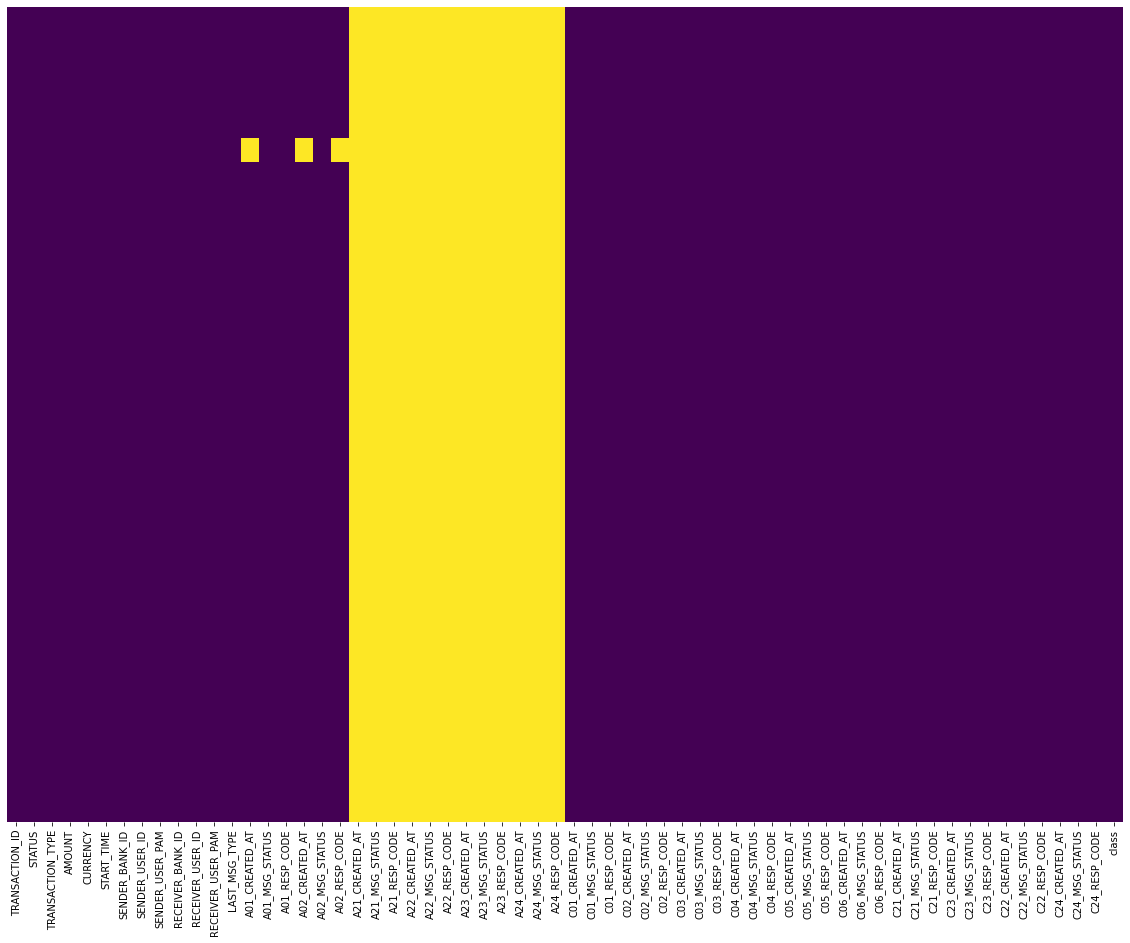

In [ ]:
# AMOUNT преобразовываем в числовой формат
new_df_p['AMOUNT'] = pd.to_numeric(new_df_p['AMOUNT'])

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# SENDER_BANK_ID
le.fit(new_df_p['SENDER_BANK_ID'])
new_df_p['SENDER_BANK_ID'] = le.transform(new_df_p['SENDER_BANK_ID'])

# SENDER_USER_ID
le.fit(new_df_p['SENDER_USER_ID'])
new_df_p['SENDER_USER_ID'] = le.transform(new_df_p['SENDER_USER_ID'])

# SENDER_USER_PAM
le.fit(new_df_p['SENDER_USER_PAM'])
new_df_p['SENDER_USER_PAM'] = le.transform(new_df_p['SENDER_USER_PAM'])

# RECEIVER_BANK_ID
le.fit(new_df_p['RECEIVER_BANK_ID'])
new_df_p['RECEIVER_BANK_ID'] = le.transform(new_df_p['RECEIVER_BANK_ID'])

# RECEIVER_USER_ID
le.fit(new_df_p['RECEIVER_USER_ID'])
new_df_p['RECEIVER_USER_ID'] = le.transform(new_df_p['RECEIVER_USER_ID'])

# для получателя заменяем пропуски на 9999
new_df_p['RECEIVER_USER_PAM'] = new_df_p['RECEIVER_USER_PAM'].replace(r'\N', str('notdescribe') )

# RECEIVER_USER_ID
le.fit(new_df_p['RECEIVER_USER_PAM'])
new_df_p['RECEIVER_USER_PAM'] = le.transform(new_df_p['RECEIVER_USER_PAM'])

#Работаем с остальными признаками (технические коды и сообщения

# Работаем с остальными признакми через label encoding
# LAST_MSG_TYPE
new_df_p['LAST_MSG_TYPE'] = new_df_p['LAST_MSG_TYPE'].astype('str')
le.fit(new_df_p['LAST_MSG_TYPE'])
new_df_p['LAST_MSG_TYPE'] = le.transform(new_df_p['LAST_MSG_TYPE'])

# A01_MSG_STATUS
new_df_p['A01_MSG_STATUS'] = new_df_p['A01_MSG_STATUS'].astype('str')
le.fit(new_df_p['A01_MSG_STATUS'])
new_df_p['A01_MSG_STATUS'] = le.transform(new_df_p['A01_MSG_STATUS'])

# A01_RESP_CODE
new_df_p['A01_RESP_CODE'] = new_df_p['A01_RESP_CODE'].astype('str')
le.fit(new_df_p['A01_RESP_CODE'])
new_df_p['A01_RESP_CODE'] = le.transform(new_df_p['A01_RESP_CODE'])

# A02_MSG_STATUS
new_df_p['A02_MSG_STATUS'] = new_df_p['A02_MSG_STATUS'].astype('str')
le.fit(new_df_p['A02_MSG_STATUS'])
new_df_p['A02_MSG_STATUS'] = le.transform(new_df_p['A02_MSG_STATUS'])

# C01_MSG_STATUS
new_df_p['C01_MSG_STATUS'] = new_df_p['C01_MSG_STATUS'].astype('str')
le.fit(new_df_p['C01_MSG_STATUS'])
new_df_p['C01_MSG_STATUS'] = le.transform(new_df_p['C01_MSG_STATUS'])

# C01_RESP_CODE
new_df_p['C01_RESP_CODE'] = new_df_p['C01_RESP_CODE'].astype('str')
le.fit(new_df_p['C01_RESP_CODE'])
new_df_p['C01_RESP_CODE'] = le.transform(new_df_p['C01_RESP_CODE'])

# C01_RESP_CODE
new_df_p['C01_RESP_CODE'] = new_df_p['C01_RESP_CODE'].astype('str')
le.fit(new_df_p['C01_RESP_CODE'])
new_df_p['C01_RESP_CODE'] = le.transform(new_df_p['C01_RESP_CODE'])

# C02_MSG_STATUS
new_df_p['C02_MSG_STATUS'] = new_df_p['C02_MSG_STATUS'].astype('str')
le.fit(new_df_p['C02_MSG_STATUS'])
new_df_p['C02_MSG_STATUS'] = le.transform(new_df_p['C02_MSG_STATUS'])

# C02_RESP_CODE
new_df_p['C02_RESP_CODE'] = new_df_p['C02_RESP_CODE'].astype('str')
le.fit(new_df_p['C02_RESP_CODE'])
new_df_p['C02_RESP_CODE'] = le.transform(new_df_p['C02_RESP_CODE'])

# C03_MSG_STATUS
new_df_p['C03_MSG_STATUS'] = new_df_p['C03_MSG_STATUS'].astype('str')
le.fit(new_df_p['C03_MSG_STATUS'])
new_df_p['C03_MSG_STATUS'] = le.transform(new_df_p['C03_MSG_STATUS'])

# C03_RESP_CODE
new_df_p['C03_RESP_CODE'] = new_df_p['C03_RESP_CODE'].astype('str')
le.fit(new_df_p['C03_RESP_CODE'])
new_df_p['C03_RESP_CODE'] = le.transform(new_df_p['C03_RESP_CODE'])

# C04_MSG_STATUS
new_df_p['C04_MSG_STATUS'] = new_df_p['C04_MSG_STATUS'].astype('str')
le.fit(new_df_p['C04_MSG_STATUS'])
new_df_p['C04_MSG_STATUS'] = le.transform(new_df_p['C04_MSG_STATUS'])

# C04_RESP_CODE
new_df_p['C04_RESP_CODE'] = new_df_p['C04_RESP_CODE'].astype('str')
le.fit(new_df_p['C04_RESP_CODE'])
new_df_p['C04_RESP_CODE'] = le.transform(new_df_p['C04_RESP_CODE'])

# C05_MSG_STATUS
new_df_p['C05_MSG_STATUS'] = new_df_p['C05_MSG_STATUS'].astype('str')
le.fit(new_df_p['C05_MSG_STATUS'])
new_df_p['C05_MSG_STATUS'] = le.transform(new_df_p['C05_MSG_STATUS'])

# C05_RESP_CODE
new_df_p['C05_RESP_CODE'] = new_df_p['C05_RESP_CODE'].astype('str')
le.fit(new_df_p['C05_RESP_CODE'])
new_df_p['C05_RESP_CODE'] = le.transform(new_df_p['C05_RESP_CODE'])

# C06_MSG_STATUS
new_df_p['C06_MSG_STATUS'] = new_df_p['C06_MSG_STATUS'].astype('str')
le.fit(new_df_p['C06_MSG_STATUS'])
new_df_p['C06_MSG_STATUS'] = le.transform(new_df_p['C06_MSG_STATUS'])

# C06_RESP_CODE
new_df_p['C06_RESP_CODE'] = new_df_p['C06_RESP_CODE'].astype('str')
le.fit(new_df_p['C06_RESP_CODE'])
new_df_p['C06_RESP_CODE'] = le.transform(new_df_p['C06_RESP_CODE'])

# C21_MSG_STATUS
new_df_p['C21_MSG_STATUS'] = new_df_p['C21_MSG_STATUS'].astype('str')
le.fit(new_df_p['C21_MSG_STATUS'])
new_df_p['C21_MSG_STATUS'] = le.transform(new_df_p['C21_MSG_STATUS'])

# C21_RESP_CODE
new_df_p['C21_RESP_CODE'] = new_df_p['C21_RESP_CODE'].astype('str')
le.fit(new_df_p['C21_RESP_CODE'])
new_df_p['C21_RESP_CODE'] = le.transform(new_df_p['C21_RESP_CODE'])

# C23_MSG_STATUS
new_df_p['C23_MSG_STATUS'] = new_df_p['C23_MSG_STATUS'].astype('str')
le.fit(new_df_p['C23_MSG_STATUS'])
new_df_p['C23_MSG_STATUS'] = le.transform(new_df_p['C23_MSG_STATUS'])

# C23_RESP_CODE
new_df_p['C23_RESP_CODE'] = new_df_p['C23_RESP_CODE'].astype('str')
le.fit(new_df_p['C23_RESP_CODE'])
new_df_p['C23_RESP_CODE'] = le.transform(new_df_p['C23_RESP_CODE'])

# C22_MSG_STATUS
new_df_p['C22_MSG_STATUS'] = new_df_p['C22_MSG_STATUS'].astype('str')
le.fit(new_df_p['C22_MSG_STATUS'])
new_df_p['C22_MSG_STATUS'] = le.transform(new_df_p['C22_MSG_STATUS'])

# C22_RESP_CODE
new_df_p['C22_RESP_CODE'] = new_df_p['C22_RESP_CODE'].astype('str')
le.fit(new_df_p['C22_RESP_CODE'])
new_df_p['C22_RESP_CODE'] = le.transform(new_df_p['C22_RESP_CODE'])

# C24_MSG_STATUS
new_df_p['C24_MSG_STATUS'] = new_df_p['C24_MSG_STATUS'].astype('str')
le.fit(new_df_p['C24_MSG_STATUS'])
new_df_p['C24_MSG_STATUS'] = le.transform(new_df_p['C24_MSG_STATUS'])

# C24_RESP_CODE
new_df_p['C24_RESP_CODE'] = new_df_p['C24_RESP_CODE'].astype('str')
le.fit(new_df_p['C24_RESP_CODE'])
new_df_p['C24_RESP_CODE'] = le.transform(new_df_p['C24_RESP_CODE'])


#заменяем оставшиеся пропуски в признаках на 999
new_df_p = new_df_p.replace(r'\N', np.nan)

# проверяем пропуски
fig, ax = plt.subplots(figsize = (20,15))
sns_heatmap = sns.heatmap(new_df_p.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')
plt.show()

###7.2 Работа с пропусками

In [ ]:
#Считаем пропуски
missing_values_table(new_df_p)

В вашем датафрейме содержится 62 колонок.
Из них 15 колонок имеют пропуски.


,Пропущенные значения,% от общего числа значений
A21_CREATED_AT,68,100.0
A21_MSG_STATUS,68,100.0
A21_RESP_CODE,68,100.0
A22_CREATED_AT,68,100.0
A22_MSG_STATUS,68,100.0
A22_RESP_CODE,68,100.0
A23_CREATED_AT,68,100.0
A23_MSG_STATUS,68,100.0
A23_RESP_CODE,68,100.0
A24_CREATED_AT,68,100.0


In [ ]:
missing_df = missing_values_table(new_df_p);
missing_columns = list(missing_df[missing_df['% от общего числа значений'] > 50].index)
print('Мы удалим %d колонок.' % len(missing_columns))
# Удаляем колонки
new_df_p = new_df_p.drop(columns = list(missing_columns))

В вашем датафрейме содержится 62 колонок.
Из них 15 колонок имеют пропуски.
Мы удалим 12 колонок.


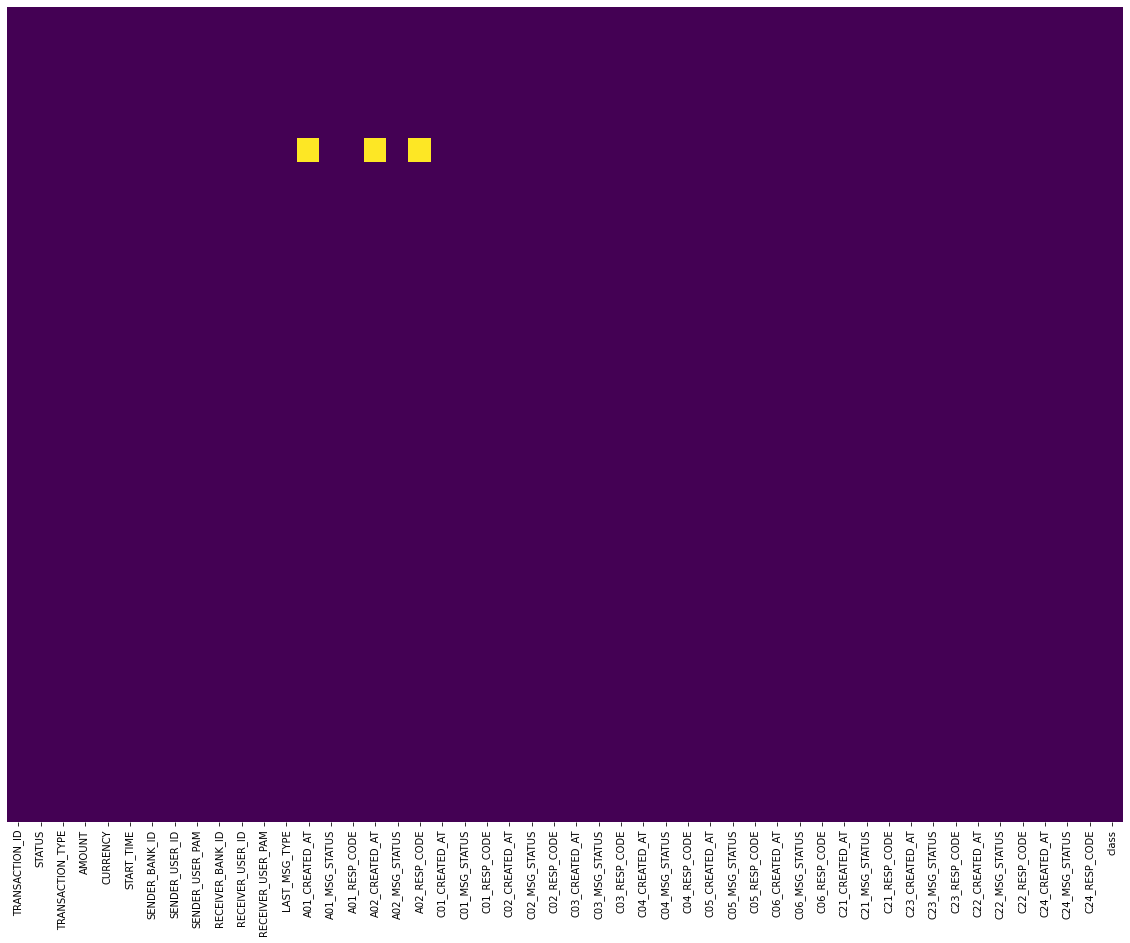

In [ ]:
# проверяем пропуски
fig, ax = plt.subplots(figsize = (20,15))
sns_heatmap = sns.heatmap(new_df_p.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')
plt.show()

In [ ]:
# принудительно меняем на dayetime признаки, которые не смогла отработать функция
new_df_p['A01_CREATED_AT'] = pd.to_datetime(new_df_p['A01_CREATED_AT'], infer_datetime_format=True)
new_df_p['A02_CREATED_AT'] = pd.to_datetime(new_df_p['A02_CREATED_AT'], infer_datetime_format=True)

In [ ]:
new_df_p.head(20)

In [ ]:
new_df_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68 entries, 105 to 135
Data columns (total 50 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   TRANSACTION_ID     68 non-null     object        
 1   STATUS             68 non-null     object        
 2   TRANSACTION_TYPE   68 non-null     object        
 3   AMOUNT             68 non-null     int64         
 4   CURRENCY           68 non-null     object        
 5   START_TIME         68 non-null     datetime64[ns]
 6   SENDER_BANK_ID     68 non-null     int64         
 7   SENDER_USER_ID     68 non-null     int64         
 8   SENDER_USER_PAM    68 non-null     int64         
 9   RECEIVER_BANK_ID   68 non-null     int64         
 10  RECEIVER_USER_ID   68 non-null     int64         
 11  RECEIVER_USER_PAM  68 non-null     int64         
 12  LAST_MSG_TYPE      68 non-null     int64         
 13  A01_CREATED_AT     66 non-null     datetime64[ns]
 14  A01_MSG_S

###7.3 Создаем дополнительные признакми по разнице во времени


In [ ]:
#dataframe with time agregation features 
df_withtf = new_df_p

In [ ]:
# Создаем и считаем дополнительные признакми
df_withtf['start-end'] = (df_withtf['C24_CREATED_AT'] - df_withtf['START_TIME']).dt.total_seconds()
df_withtf['start-a01'] = (df_withtf['A01_CREATED_AT'] - df_withtf['START_TIME']).dt.total_seconds()
df_withtf['a01-a02'] = (df_withtf['A02_CREATED_AT'] - df_withtf['A01_CREATED_AT']).dt.total_seconds()
df_withtf['a02-c01'] = (df_withtf['C01_CREATED_AT'] - df_withtf['A02_CREATED_AT']).dt.total_seconds()
df_withtf['c01-c02'] = (df_withtf['C02_CREATED_AT'] - df_withtf['C01_CREATED_AT']).dt.total_seconds()
df_withtf['c02-c03'] = (df_withtf['C03_CREATED_AT'] - df_withtf['C02_CREATED_AT']).dt.total_seconds()
df_withtf['c03-c04'] = (df_withtf['C04_CREATED_AT'] - df_withtf['C03_CREATED_AT']).dt.total_seconds()
df_withtf['c04-c05'] = (df_withtf['C05_CREATED_AT'] - df_withtf['C04_CREATED_AT']).dt.total_seconds()
df_withtf['c05-c06'] = (df_withtf['C06_CREATED_AT'] - df_withtf['C05_CREATED_AT']).dt.total_seconds()
df_withtf['c06-c21'] = (df_withtf['C21_CREATED_AT'] - df_withtf['C06_CREATED_AT']).dt.total_seconds()
df_withtf['c21-c23'] = (df_withtf['C23_CREATED_AT'] - df_withtf['C21_CREATED_AT']).dt.total_seconds()
df_withtf['c23-c22'] = (df_withtf['C22_CREATED_AT'] - df_withtf['C23_CREATED_AT']).dt.total_seconds()
df_withtf['c22-c24'] = (df_withtf['C24_CREATED_AT'] - df_withtf['C22_CREATED_AT']).dt.total_seconds()

In [ ]:
df_withtf.head(20)

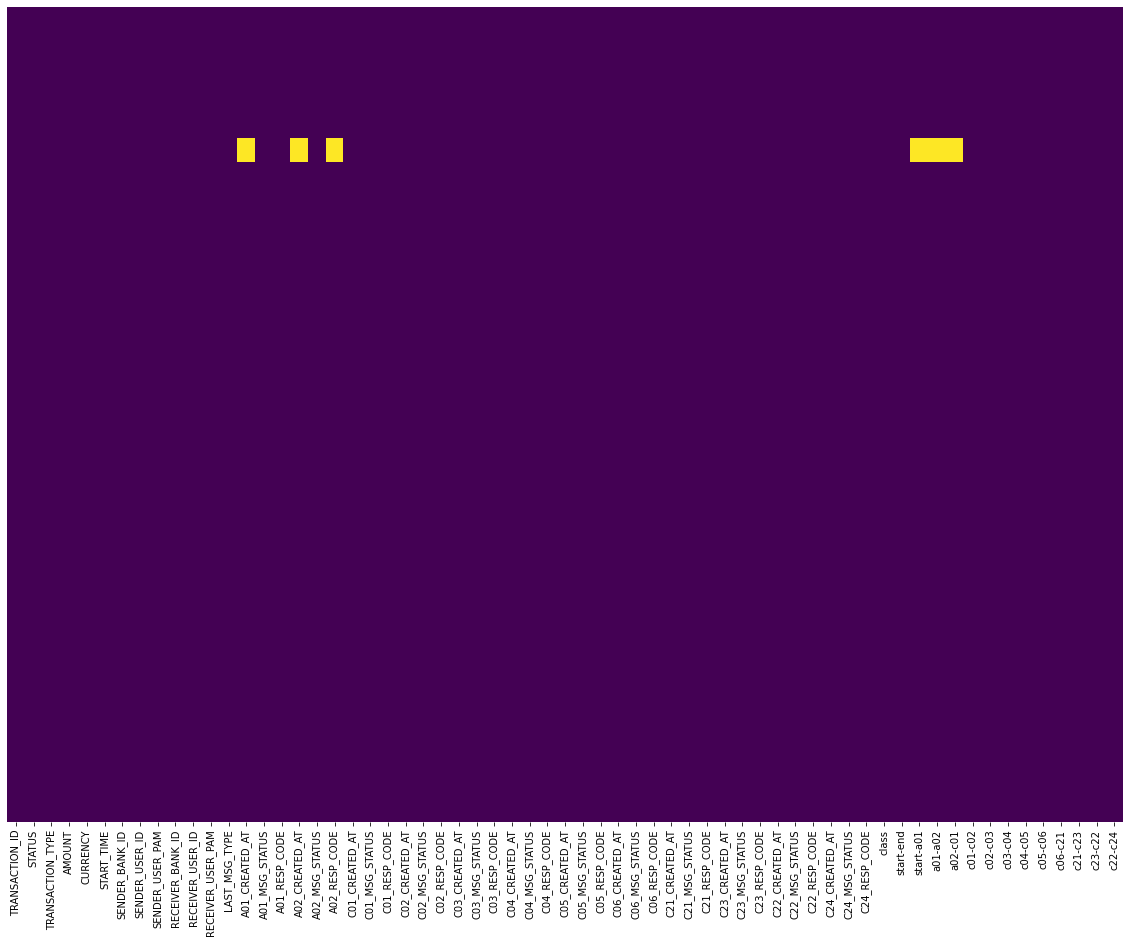

In [ ]:
# проверяем пропуски
fig, ax = plt.subplots(figsize = (20,15))
sns_heatmap = sns.heatmap(df_withtf.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')
plt.show()

In [ ]:
df_withtf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68 entries, 105 to 135
Data columns (total 63 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   TRANSACTION_ID     68 non-null     object        
 1   STATUS             68 non-null     object        
 2   TRANSACTION_TYPE   68 non-null     object        
 3   AMOUNT             68 non-null     int64         
 4   CURRENCY           68 non-null     object        
 5   START_TIME         68 non-null     datetime64[ns]
 6   SENDER_BANK_ID     68 non-null     int64         
 7   SENDER_USER_ID     68 non-null     int64         
 8   SENDER_USER_PAM    68 non-null     int64         
 9   RECEIVER_BANK_ID   68 non-null     int64         
 10  RECEIVER_USER_ID   68 non-null     int64         
 11  RECEIVER_USER_PAM  68 non-null     int64         
 12  LAST_MSG_TYPE      68 non-null     int64         
 13  A01_CREATED_AT     66 non-null     datetime64[ns]
 14  A01_MSG_S

#8.Анализ на сбалансированном датасете

##8.1 Анализ на сбалансированном датасете

Распределение классов 
1    0.5
0    0.5
Name: class, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


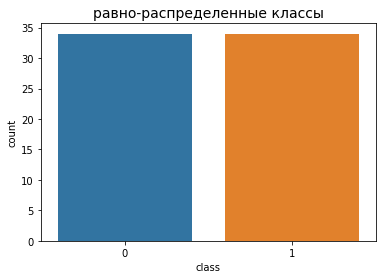

In [ ]:
print('Распределение классов ')
print(df_withtf['class'].value_counts()/len(new_df))
sns.countplot('class', data=new_df)
plt.title('равно-распределенные классы', fontsize=14)
plt.show()

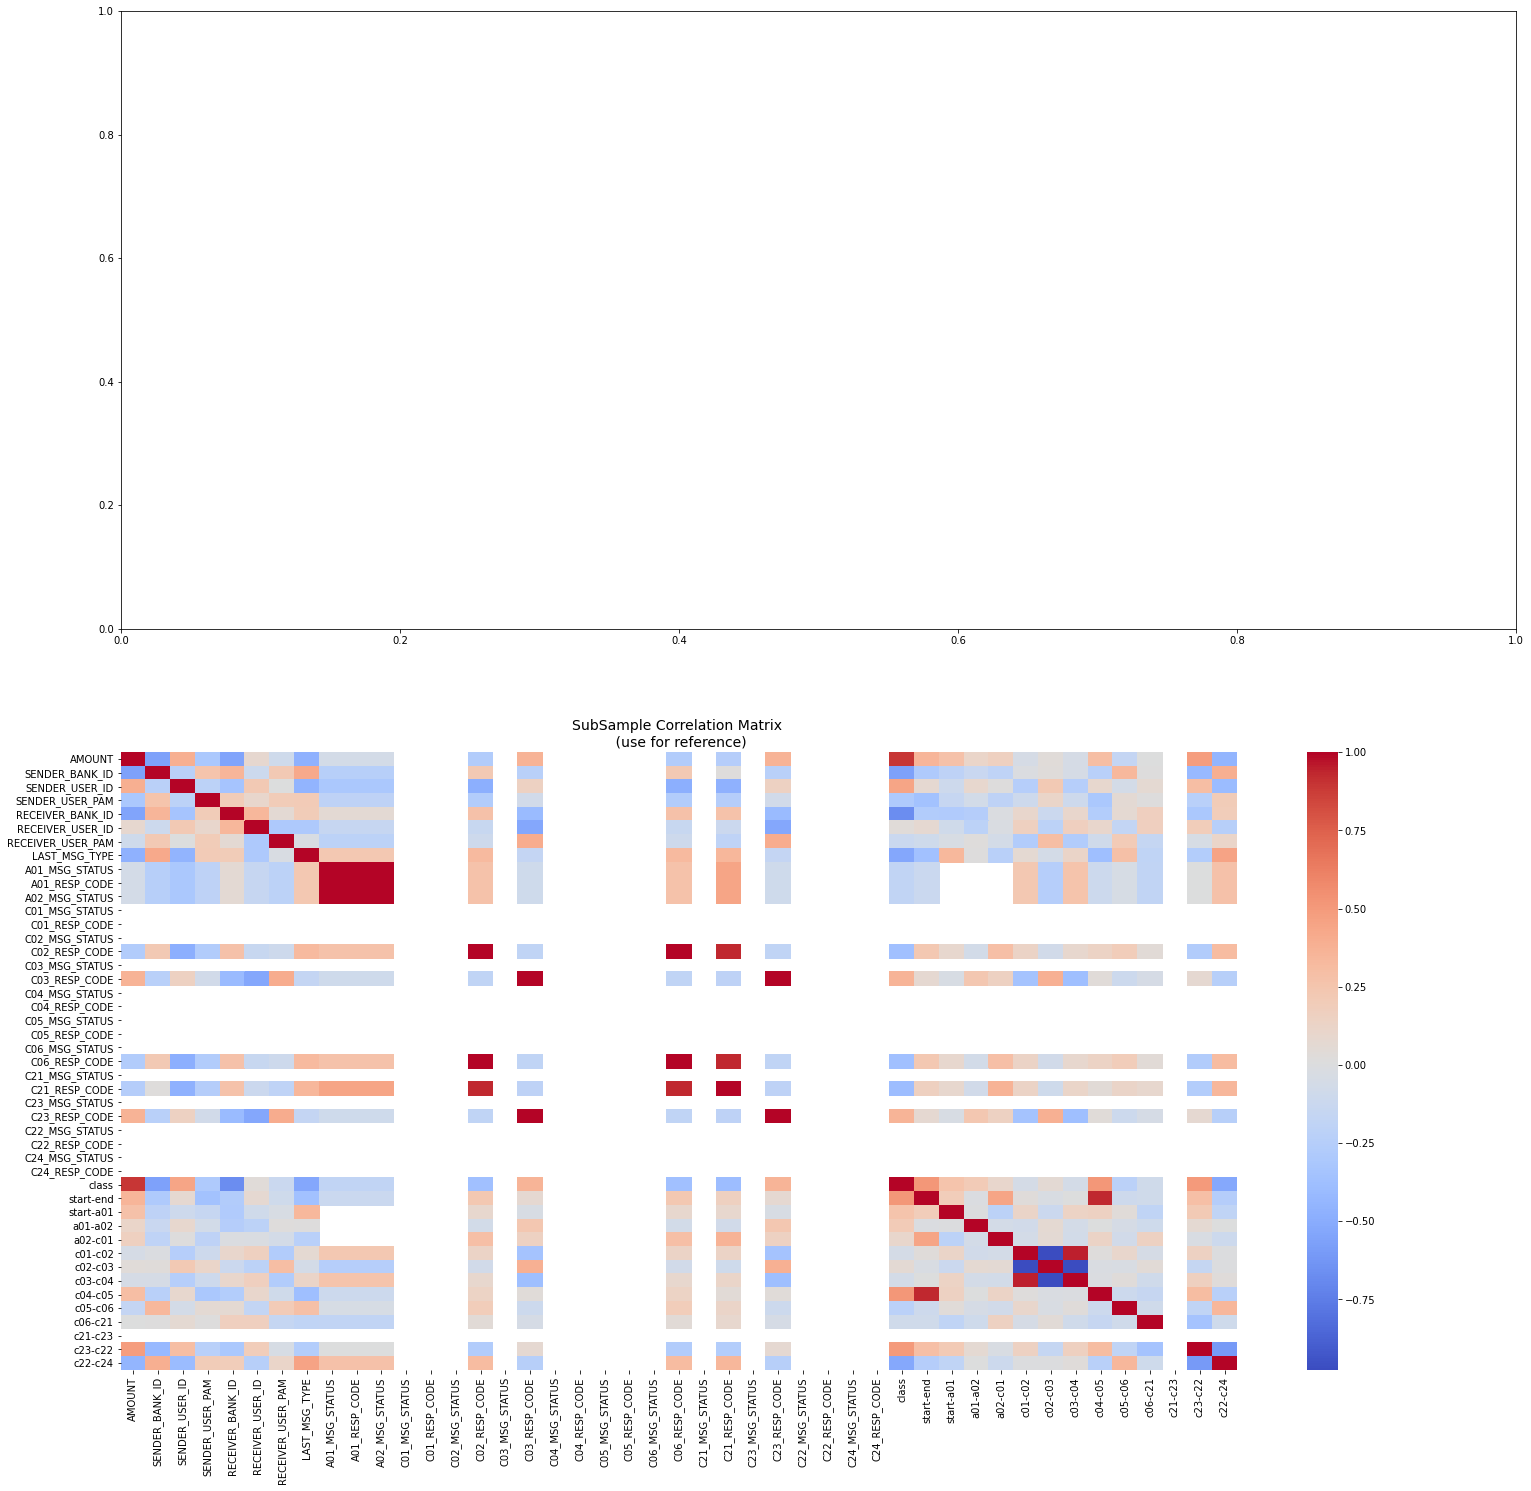

In [ ]:
# Создаем полотно
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(25,25))

# Вводим даные
#corr = data.corr() # разбалансированный датасет
#sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
#ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

sub_sample_corr = df_withtf.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

##8.2 Распределение коррелируемых фичей

Фичи:

RECEIVER_BANK_ID

c04-c05

c23-c22





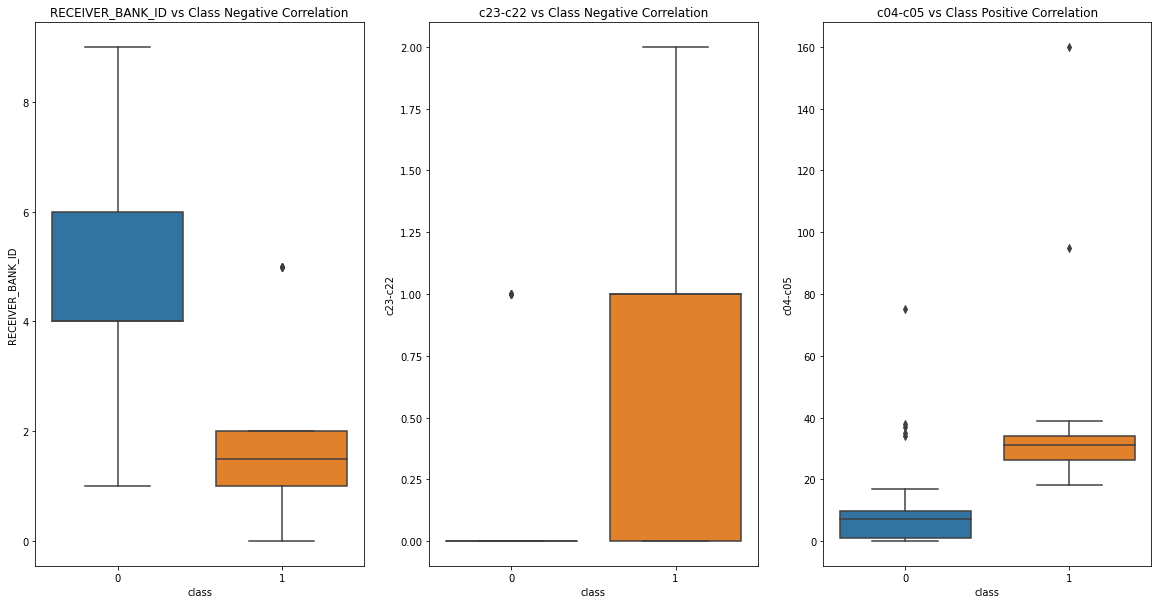

In [ ]:
f, axes = plt.subplots(ncols=3, figsize=(20,10))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)

sns.boxplot(x="class", y="RECEIVER_BANK_ID", data=df_withtf,  ax=axes[0])
axes[0].set_title('RECEIVER_BANK_ID vs Class Negative Correlation')

sns.boxplot(x="class", y="c23-c22", data=df_withtf, ax=axes[1])
axes[1].set_title('c23-c22 vs Class Negative Correlation')

sns.boxplot(x="class", y="c04-c05", data=df_withtf,  ax=axes[2])
axes[2].set_title('c04-c05 vs Class Positive Correlation')

plt.show()

###8.2.1 Распределение фичей для мошеннических операций

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

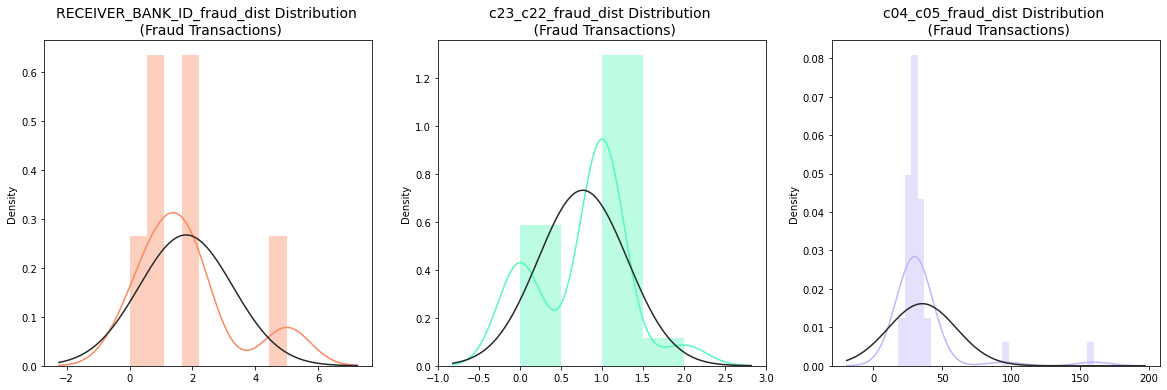

In [ ]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

RECEIVER_BANK_ID_fraud_dist = df_withtf['RECEIVER_BANK_ID'].loc[df_withtf['class'] == 1].values
sns.distplot(RECEIVER_BANK_ID_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('RECEIVER_BANK_ID_fraud_dist Distribution \n (Fraud Transactions)', fontsize=14)

c23_c22_fraud_dist = df_withtf['c23-c22'].loc[df_withtf['class'] == 1].values
sns.distplot(c23_c22_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('c23_c22_fraud_dist Distribution \n (Fraud Transactions)', fontsize=14)


c04_c05_fraud_dist = df_withtf['c04-c05'].loc[df_withtf['class'] == 1].values
sns.distplot(c04_c05_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('c04_c05_fraud_dist Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

###8.2.2 Распределение фичей для нормальныйх операций

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

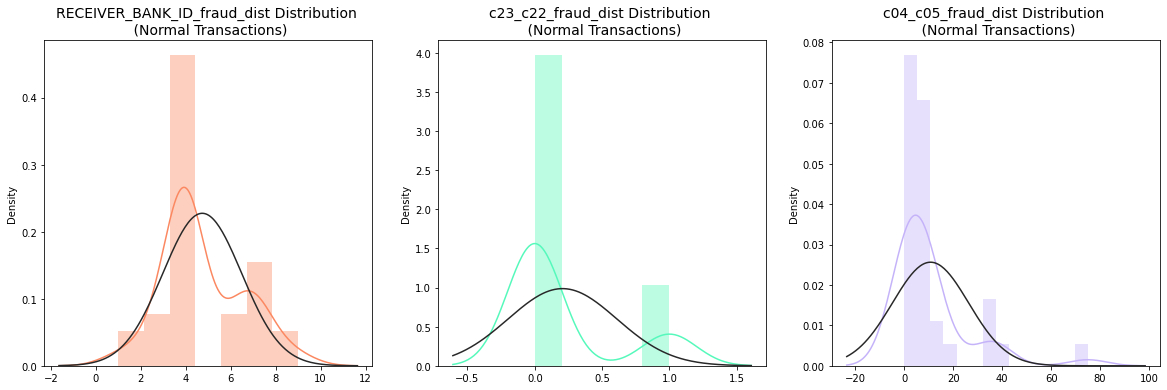

In [ ]:

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

RECEIVER_BANK_ID_fraud_dist = df_withtf['RECEIVER_BANK_ID'].loc[df_withtf['class'] == 0].values
sns.distplot(RECEIVER_BANK_ID_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('RECEIVER_BANK_ID_fraud_dist Distribution \n (Normal Transactions)', fontsize=14)

c23_c22_fraud_dist = df_withtf['c23-c22'].loc[df_withtf['class'] == 0].values
sns.distplot(c23_c22_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('c23_c22_fraud_dist Distribution \n (Normal Transactions)', fontsize=14)


c04_c05_fraud_dist = df_withtf['c04-c05'].loc[df_withtf['class'] == 0].values
sns.distplot(c04_c05_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('c04_c05_fraud_dist Distribution \n (Normal Transactions)', fontsize=14)

plt.show()

##8.3 Временной промежуток между fraud

In [ ]:
mask_fraud = df_withtf['class'] == 1
fraud_withtf = df_withtf[mask_fraud]

fraud_withtf = fraud_withtf.sort_values(by = 'START_TIME', ascending= True)
fraud_withtf['fraudtimediff'] = (fraud_withtf['START_TIME'] - fraud_withtf['START_TIME'].shift()).dt.total_seconds()
fraud_withtf.head()

In [ ]:
# Смотрим промежутки
fraud_withtf.fraudtimediff

0       NaN
1     957.0
24    445.0
8     167.0
2      56.0
3      68.0
25     79.0
6     106.0
4      96.0
26     79.0
27     72.0
7      92.0
28     72.0
5      63.0
9     139.0
12     74.0
10     92.0
11     67.0
17    773.0
18    127.0
19     89.0
14     70.0
15    158.0
16     51.0
13     45.0
31     68.0
29     84.0
20     53.0
21    164.0
22     67.0
33     72.0
23     50.0
30     56.0
32    702.0
Name: fraudtimediff, dtype: float64

##8.4 t-sne на сбалансированном датасете

In [ ]:
#Лист признаков, которые удалим из датафрейма (временные метки)
drop_list = ['class','TRANSACTION_ID', 'STATUS', 'TRANSACTION_TYPE', 'CURRENCY',\
            'START_TIME', 'A01_CREATED_AT', 'A02_CREATED_AT', 'C01_CREATED_AT', 'C02_CREATED_AT', 'C03_CREATED_AT',\
             'C04_CREATED_AT','C05_CREATED_AT', 'C06_CREATED_AT', 'C21_CREATED_AT', 'C23_CREATED_AT', 'C22_CREATED_AT', 'C24_CREATED_AT' ]
#удаляем признаки
X_plt = df_withtf.drop(drop_list, axis = 1).fillna(0)
# Целевая переменная
y_plt = df_withtf['class']

X_plt.head(3)

,AMOUNT,SENDER_BANK_ID,SENDER_USER_ID,SENDER_USER_PAM,RECEIVER_BANK_ID,RECEIVER_USER_ID,RECEIVER_USER_PAM,LAST_MSG_TYPE,A01_MSG_STATUS,A01_RESP_CODE,A02_MSG_STATUS,A02_RESP_CODE,C01_MSG_STATUS,C01_RESP_CODE,C02_MSG_STATUS,C02_RESP_CODE,C03_MSG_STATUS,C03_RESP_CODE,C04_MSG_STATUS,C04_RESP_CODE,C05_MSG_STATUS,C05_RESP_CODE,C06_MSG_STATUS,C06_RESP_CODE,C21_MSG_STATUS,C21_RESP_CODE,C23_MSG_STATUS,C23_RESP_CODE,C22_MSG_STATUS,C22_RESP_CODE,C24_MSG_STATUS,C24_RESP_CODE,start-end,start-a01,a01-a02,a02-c01,c01-c02,c02-c03,c03-c04,c04-c05,c05-c06,c06-c21,c21-c23,c23-c22,c22-c24
105,100000,1,28,33,7,30,29,1,0,0,0,200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.0,-1.0,0.0,1.0,0.0,0.0,0.0,7.0,0.0,1.0,0.0,0.0,0.0
16,3000000,2,23,12,1,3,28,1,0,0,0,200,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,29.0,0.0,0.0,5.0,1.0,-1.0,1.0,22.0,0.0,1.0,0.0,0.0,0.0
4,3000000,2,23,12,2,16,18,1,0,0,0,200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38.0,0.0,0.0,4.0,1.0,-1.0,1.0,32.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
#Создаем кластеризацию на два класса tsne
X_embedded = TSNE(n_components=2).fit_transform(X_plt)

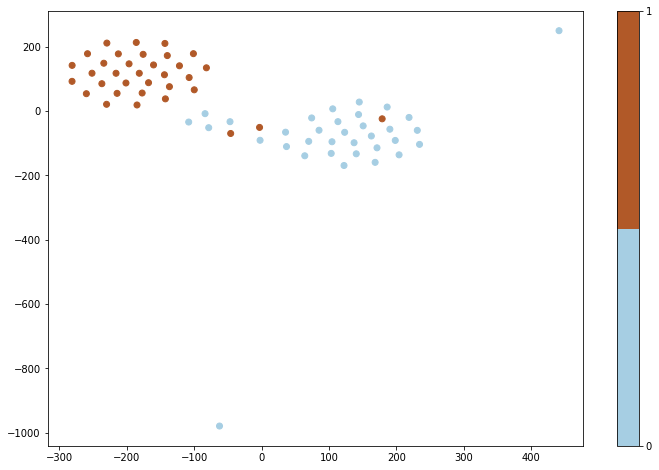

In [ ]:
#визуализируем
plt.figure(figsize=(12,8))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y_plt, cmap=plt.cm.get_cmap("Paired", 2))
plt.colorbar(ticks=range(2))

#9.Анализ на разбалансированном датасете

##9.1 Предобработка разбалансированного датасета

In [ ]:
#Создаем датафрейм с дисбалансом
#disbal_distributed_df = pd.concat([fraud_data, not_fraud_data_ms])
disbal_distributed_df = disbal_distributed_df[:3500]
disbal_distributed_df.head()

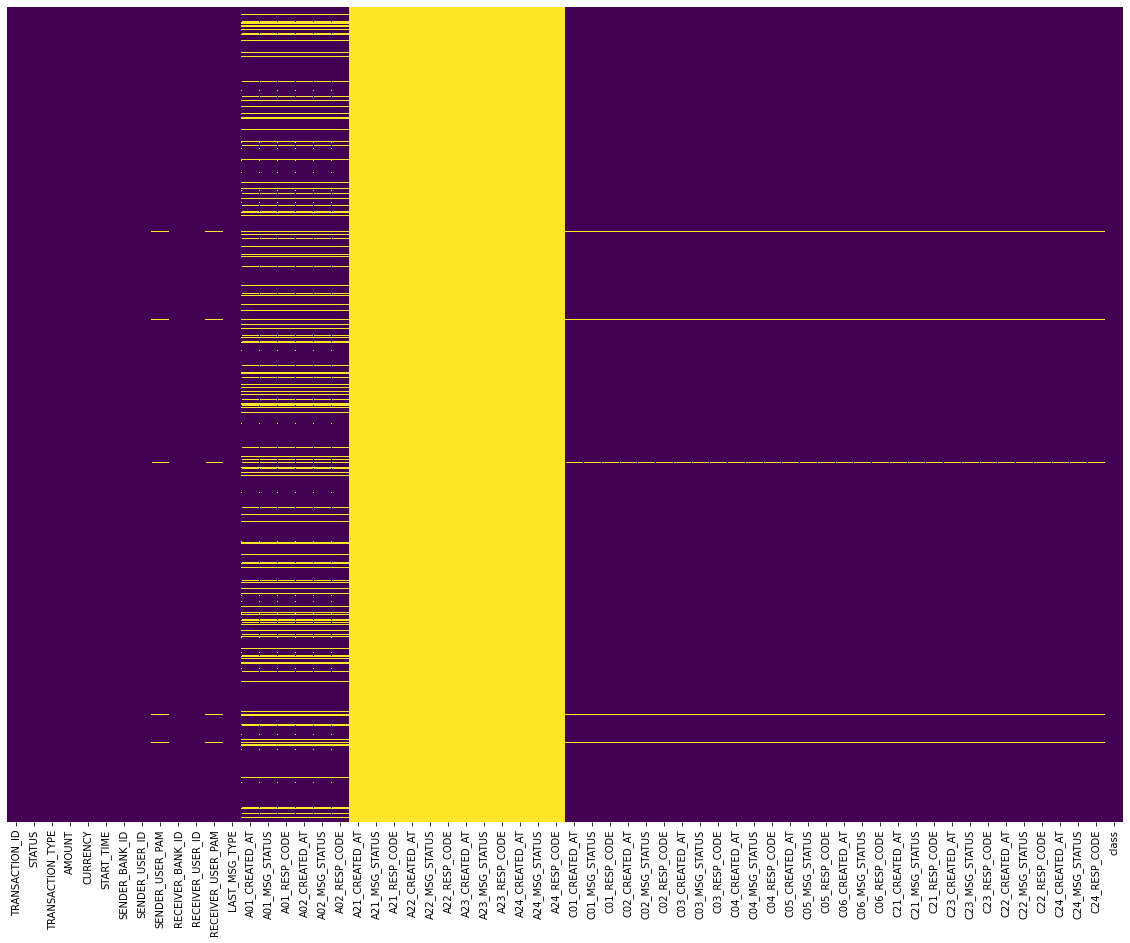

In [ ]:
#заменяем оставшиеся пропуски в признаках на 999
disbal_distributed_df = disbal_distributed_df.replace(r'\N', np.nan)

# проверяем пропуски
fig, ax = plt.subplots(figsize = (20,15))
sns_heatmap = sns.heatmap(disbal_distributed_df.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')
plt.show()

In [ ]:
missing_values_table(disbal_distributed_df)

В вашем датафрейме содержится 62 колонок.
Из них 50 колонок имеют пропуски.


,Пропущенные значения,% от общего числа значений
A24_CREATED_AT,63871,100.0
A21_MSG_STATUS,63871,100.0
A24_MSG_STATUS,63871,100.0
A23_RESP_CODE,63871,100.0
A23_MSG_STATUS,63871,100.0
A23_CREATED_AT,63871,100.0
A22_RESP_CODE,63871,100.0
A22_MSG_STATUS,63871,100.0
A22_CREATED_AT,63871,100.0
A21_RESP_CODE,63871,100.0


In [ ]:
missing_df = missing_values_table(disbal_distributed_df);
missing_columns = list(missing_df[missing_df['% от общего числа значений'] > 50].index)
print('Мы удалим %d колонок.' % len(missing_columns))
# Удаляем колонки
disbal_distributed_df = disbal_distributed_df.drop(columns = list(missing_columns))
print('Успешно удалено %d колонок.' % len(missing_columns))

В вашем датафрейме содержится 62 колонок.
Из них 50 колонок имеют пропуски.
Мы удалим 12 колонок.
Успешно удалено 12 колонок.


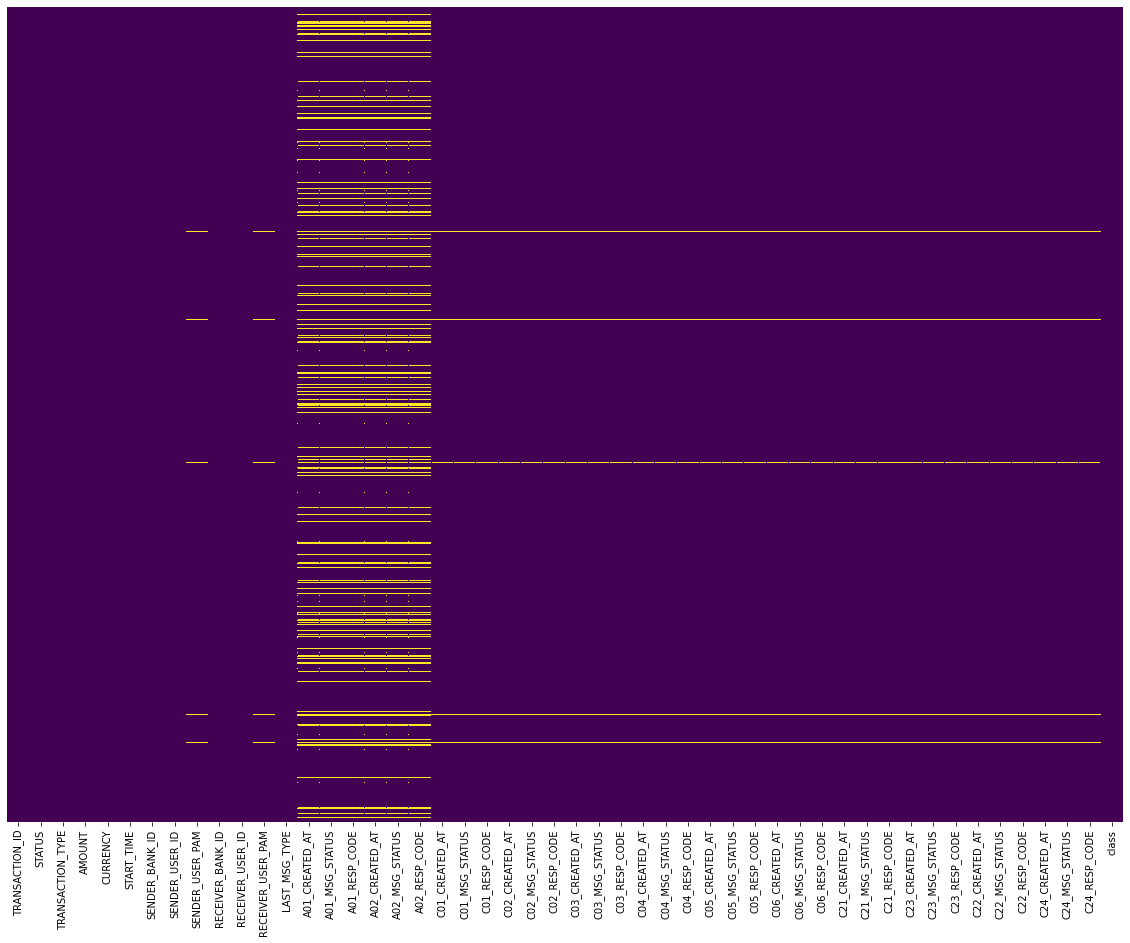

In [ ]:
# проверяем пропуски
fig, ax = plt.subplots(figsize = (20,15))
sns_heatmap = sns.heatmap(disbal_distributed_df.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')
plt.show()

In [ ]:
disbal_distributed_df = disbal_distributed_df.fillna(method='ffill')

In [ ]:
dateTimeConvert(disbal_distributed_df)
disbal_distributed_df.info()

cant convert TRANSACTION_ID
cant convert STATUS
cant convert TRANSACTION_TYPE
cant convert AMOUNT
cant convert CURRENCY
for START_TIME convert success
cant convert SENDER_BANK_ID
cant convert SENDER_USER_ID
cant convert SENDER_USER_PAM
cant convert RECEIVER_BANK_ID
cant convert RECEIVER_USER_ID
cant convert RECEIVER_USER_PAM
cant convert LAST_MSG_TYPE
for A01_CREATED_AT convert success
cant convert A01_MSG_STATUS
cant convert A01_RESP_CODE
for A02_CREATED_AT convert success
cant convert A02_MSG_STATUS
cant convert A02_RESP_CODE
cant convert A21_CREATED_AT
cant convert A21_MSG_STATUS
cant convert A21_RESP_CODE
cant convert A22_CREATED_AT
cant convert A22_MSG_STATUS
cant convert A22_RESP_CODE
cant convert A23_CREATED_AT
cant convert A23_MSG_STATUS
cant convert A23_RESP_CODE
cant convert A24_CREATED_AT
cant convert A24_MSG_STATUS
cant convert A24_RESP_CODE
for C01_CREATED_AT convert success
cant convert C01_MSG_STATUS
cant convert C01_RESP_CODE
for C02_CREATED_AT convert success
cant conv

In [ ]:
# AMOUNT преобразовываем в числовой формат
disbal_distributed_df['AMOUNT'] = pd.to_numeric(disbal_distributed_df['AMOUNT'])

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# SENDER_BANK_ID
le.fit(disbal_distributed_df['SENDER_BANK_ID'])
disbal_distributed_df['SENDER_BANK_ID'] = le.transform(disbal_distributed_df['SENDER_BANK_ID'])

# SENDER_USER_ID
le.fit(disbal_distributed_df['SENDER_USER_ID'])
disbal_distributed_df['SENDER_USER_ID'] = le.transform(disbal_distributed_df['SENDER_USER_ID'])

# SENDER_USER_PAM
le.fit(disbal_distributed_df['SENDER_USER_PAM'])
disbal_distributed_df['SENDER_USER_PAM'] = le.transform(disbal_distributed_df['SENDER_USER_PAM'])

# RECEIVER_BANK_ID
le.fit(disbal_distributed_df['RECEIVER_BANK_ID'])
disbal_distributed_df['RECEIVER_BANK_ID'] = le.transform(disbal_distributed_df['RECEIVER_BANK_ID'])

# RECEIVER_USER_ID
le.fit(disbal_distributed_df['RECEIVER_USER_ID'])
disbal_distributed_df['RECEIVER_USER_ID'] = le.transform(disbal_distributed_df['RECEIVER_USER_ID'])

# для получателя заменяем пропуски на 9999
disbal_distributed_df['RECEIVER_USER_PAM'] = disbal_distributed_df['RECEIVER_USER_PAM'].replace(r'\N', str('notdescribe') )

# RECEIVER_USER_ID
le.fit(disbal_distributed_df['RECEIVER_USER_PAM'])
disbal_distributed_df['RECEIVER_USER_PAM'] = le.transform(disbal_distributed_df['RECEIVER_USER_PAM'])

#Работаем с остальными признаками (технические коды и сообщения

# Работаем с остальными признакми через label encoding
# LAST_MSG_TYPE
disbal_distributed_df['LAST_MSG_TYPE'] = disbal_distributed_df['LAST_MSG_TYPE'].astype('str')
le.fit(disbal_distributed_df['LAST_MSG_TYPE'])
disbal_distributed_df['LAST_MSG_TYPE'] = le.transform(disbal_distributed_df['LAST_MSG_TYPE'])

# A01_MSG_STATUS
disbal_distributed_df['A01_MSG_STATUS'] = disbal_distributed_df['A01_MSG_STATUS'].astype('str')
le.fit(disbal_distributed_df['A01_MSG_STATUS'])
disbal_distributed_df['A01_MSG_STATUS'] = le.transform(disbal_distributed_df['A01_MSG_STATUS'])

# A01_RESP_CODE
disbal_distributed_df['A01_RESP_CODE'] = disbal_distributed_df['A01_RESP_CODE'].astype('str')
le.fit(disbal_distributed_df['A01_RESP_CODE'])
disbal_distributed_df['A01_RESP_CODE'] = le.transform(disbal_distributed_df['A01_RESP_CODE'])

# A02_MSG_STATUS
disbal_distributed_df['A02_MSG_STATUS'] = disbal_distributed_df['A02_MSG_STATUS'].astype('str')
le.fit(disbal_distributed_df['A02_MSG_STATUS'])
disbal_distributed_df['A02_MSG_STATUS'] = le.transform(disbal_distributed_df['A02_MSG_STATUS'])

# C01_MSG_STATUS
disbal_distributed_df['C01_MSG_STATUS'] = disbal_distributed_df['C01_MSG_STATUS'].astype('str')
le.fit(disbal_distributed_df['C01_MSG_STATUS'])
disbal_distributed_df['C01_MSG_STATUS'] = le.transform(disbal_distributed_df['C01_MSG_STATUS'])

# C01_RESP_CODE
disbal_distributed_df['C01_RESP_CODE'] = disbal_distributed_df['C01_RESP_CODE'].astype('str')
le.fit(disbal_distributed_df['C01_RESP_CODE'])
disbal_distributed_df['C01_RESP_CODE'] = le.transform(disbal_distributed_df['C01_RESP_CODE'])

# C01_RESP_CODE
disbal_distributed_df['C01_RESP_CODE'] = disbal_distributed_df['C01_RESP_CODE'].astype('str')
le.fit(disbal_distributed_df['C01_RESP_CODE'])
disbal_distributed_df['C01_RESP_CODE'] = le.transform(disbal_distributed_df['C01_RESP_CODE'])

# C02_MSG_STATUS
disbal_distributed_df['C02_MSG_STATUS'] = disbal_distributed_df['C02_MSG_STATUS'].astype('str')
le.fit(disbal_distributed_df['C02_MSG_STATUS'])
#disbal_distributed_df['C02_MSG_STATUS'] = le.transform(disbal_distributed_df['C02_MSG_STATUS'])

# C02_RESP_CODE
disbal_distributed_df['C02_RESP_CODE'] = disbal_distributed_df['C02_RESP_CODE'].astype('str')
le.fit(disbal_distributed_df['C02_RESP_CODE'])
disbal_distributed_df['C02_RESP_CODE'] = le.transform(disbal_distributed_df['C02_RESP_CODE'])

# C03_MSG_STATUS
disbal_distributed_df['C03_MSG_STATUS'] = disbal_distributed_df['C03_MSG_STATUS'].astype('str')
le.fit(disbal_distributed_df['C03_MSG_STATUS'])
disbal_distributed_df['C03_MSG_STATUS'] = le.transform(disbal_distributed_df['C03_MSG_STATUS'])

# C03_RESP_CODE
disbal_distributed_df['C03_RESP_CODE'] = disbal_distributed_df['C03_RESP_CODE'].astype('str')
le.fit(disbal_distributed_df['C03_RESP_CODE'])
disbal_distributed_df['C03_RESP_CODE'] = le.transform(disbal_distributed_df['C03_RESP_CODE'])

# C04_MSG_STATUS
disbal_distributed_df['C04_MSG_STATUS'] = disbal_distributed_df['C04_MSG_STATUS'].astype('str')
le.fit(disbal_distributed_df['C04_MSG_STATUS'])
disbal_distributed_df['C04_MSG_STATUS'] = le.transform(disbal_distributed_df['C04_MSG_STATUS'])

# C04_RESP_CODE
disbal_distributed_df['C04_RESP_CODE'] = disbal_distributed_df['C04_RESP_CODE'].astype('str')
le.fit(disbal_distributed_df['C04_RESP_CODE'])
disbal_distributed_df['C04_RESP_CODE'] = le.transform(disbal_distributed_df['C04_RESP_CODE'])

# C05_MSG_STATUS
disbal_distributed_df['C05_MSG_STATUS'] = disbal_distributed_df['C05_MSG_STATUS'].astype('str')
le.fit(disbal_distributed_df['C05_MSG_STATUS'])
disbal_distributed_df['C05_MSG_STATUS'] = le.transform(disbal_distributed_df['C05_MSG_STATUS'])

# C05_RESP_CODE
disbal_distributed_df['C05_RESP_CODE'] = disbal_distributed_df['C05_RESP_CODE'].astype('str')
le.fit(disbal_distributed_df['C05_RESP_CODE'])
disbal_distributed_df['C05_RESP_CODE'] = le.transform(disbal_distributed_df['C05_RESP_CODE'])

# C06_MSG_STATUS
disbal_distributed_df['C06_MSG_STATUS'] = disbal_distributed_df['C06_MSG_STATUS'].astype('str')
le.fit(disbal_distributed_df['C06_MSG_STATUS'])
disbal_distributed_df['C06_MSG_STATUS'] = le.transform(disbal_distributed_df['C06_MSG_STATUS'])

# C06_RESP_CODE
disbal_distributed_df['C06_RESP_CODE'] = disbal_distributed_df['C06_RESP_CODE'].astype('str')
le.fit(disbal_distributed_df['C06_RESP_CODE'])
disbal_distributed_df['C06_RESP_CODE'] = le.transform(disbal_distributed_df['C06_RESP_CODE'])

# C21_MSG_STATUS
disbal_distributed_df['C21_MSG_STATUS'] = disbal_distributed_df['C21_MSG_STATUS'].astype('str')
le.fit(disbal_distributed_df['C21_MSG_STATUS'])
disbal_distributed_df['C21_MSG_STATUS'] = le.transform(disbal_distributed_df['C21_MSG_STATUS'])

# C21_RESP_CODE
disbal_distributed_df['C21_RESP_CODE'] = disbal_distributed_df['C21_RESP_CODE'].astype('str')
le.fit(disbal_distributed_df['C21_RESP_CODE'])
disbal_distributed_df['C21_RESP_CODE'] = le.transform(disbal_distributed_df['C21_RESP_CODE'])

# C23_MSG_STATUS
disbal_distributed_df['C23_MSG_STATUS'] = disbal_distributed_df['C23_MSG_STATUS'].astype('str')
le.fit(disbal_distributed_df['C23_MSG_STATUS'])
disbal_distributed_df['C23_MSG_STATUS'] = le.transform(disbal_distributed_df['C23_MSG_STATUS'])

# C23_RESP_CODE
disbal_distributed_df['C23_RESP_CODE'] = disbal_distributed_df['C23_RESP_CODE'].astype('str')
le.fit(disbal_distributed_df['C23_RESP_CODE'])
disbal_distributed_df['C23_RESP_CODE'] = le.transform(disbal_distributed_df['C23_RESP_CODE'])

# C22_MSG_STATUS
disbal_distributed_df['C22_MSG_STATUS'] = disbal_distributed_df['C22_MSG_STATUS'].astype('str')
le.fit(disbal_distributed_df['C22_MSG_STATUS'])
disbal_distributed_df['C22_MSG_STATUS'] = le.transform(disbal_distributed_df['C22_MSG_STATUS'])

# C22_RESP_CODE
disbal_distributed_df['C22_RESP_CODE'] = disbal_distributed_df['C22_RESP_CODE'].astype('str')
le.fit(disbal_distributed_df['C22_RESP_CODE'])
disbal_distributed_df['C22_RESP_CODE'] = le.transform(disbal_distributed_df['C22_RESP_CODE'])

# C24_MSG_STATUS
disbal_distributed_df['C24_MSG_STATUS'] = disbal_distributed_df['C24_MSG_STATUS'].astype('str')
le.fit(disbal_distributed_df['C24_MSG_STATUS'])
disbal_distributed_df['C24_MSG_STATUS'] = le.transform(disbal_distributed_df['C24_MSG_STATUS'])

# C24_RESP_CODE
disbal_distributed_df['C24_RESP_CODE'] = disbal_distributed_df['C24_RESP_CODE'].astype('str')
le.fit(disbal_distributed_df['C24_RESP_CODE'])
disbal_distributed_df['C24_RESP_CODE'] = le.transform(disbal_distributed_df['C24_RESP_CODE'])



In [ ]:
disbal_distributed_df['A01_CREATED_AT'] = pd.to_datetime(disbal_distributed_df['A01_CREATED_AT'], infer_datetime_format=True)
disbal_distributed_df['A02_CREATED_AT'] = pd.to_datetime(disbal_distributed_df['A02_CREATED_AT'], infer_datetime_format=True)

In [ ]:
disbal_distributed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63871 entries, 41340 to 56388
Data columns (total 50 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   TRANSACTION_ID     63871 non-null  object        
 1   STATUS             63871 non-null  object        
 2   TRANSACTION_TYPE   63871 non-null  object        
 3   AMOUNT             63871 non-null  int64         
 4   CURRENCY           63871 non-null  object        
 5   START_TIME         63871 non-null  datetime64[ns]
 6   SENDER_BANK_ID     63871 non-null  int64         
 7   SENDER_USER_ID     63871 non-null  int64         
 8   SENDER_USER_PAM    63871 non-null  int64         
 9   RECEIVER_BANK_ID   63871 non-null  int64         
 10  RECEIVER_USER_ID   63871 non-null  int64         
 11  RECEIVER_USER_PAM  63871 non-null  int64         
 12  LAST_MSG_TYPE      63871 non-null  int64         
 13  A01_CREATED_AT     63871 non-null  datetime64[ns]
 14  A0

In [ ]:
disbal_distributed_df.head()

In [ ]:
disbal_distributed_df['start-end'] = (disbal_distributed_df['C24_CREATED_AT'] - disbal_distributed_df['START_TIME']).dt.total_seconds()
disbal_distributed_df['start-a01'] = (disbal_distributed_df['A01_CREATED_AT'] - disbal_distributed_df['START_TIME']).dt.total_seconds()
disbal_distributed_df['a01-a02'] = (disbal_distributed_df['A02_CREATED_AT'] - disbal_distributed_df['A01_CREATED_AT']).dt.total_seconds()
disbal_distributed_df['a02-c01'] = (disbal_distributed_df['C01_CREATED_AT'] - disbal_distributed_df['A02_CREATED_AT']).dt.total_seconds()
disbal_distributed_df['c01-c02'] = (disbal_distributed_df['C02_CREATED_AT'] - disbal_distributed_df['C01_CREATED_AT']).dt.total_seconds()
disbal_distributed_df['c02-c03'] = (disbal_distributed_df['C03_CREATED_AT'] - disbal_distributed_df['C02_CREATED_AT']).dt.total_seconds()
disbal_distributed_df['c03-c04'] = (disbal_distributed_df['C04_CREATED_AT'] - disbal_distributed_df['C03_CREATED_AT']).dt.total_seconds()
disbal_distributed_df['c04-c05'] = (disbal_distributed_df['C05_CREATED_AT'] - disbal_distributed_df['C04_CREATED_AT']).dt.total_seconds()
disbal_distributed_df['c05-c06'] = (disbal_distributed_df['C06_CREATED_AT'] - disbal_distributed_df['C05_CREATED_AT']).dt.total_seconds()
disbal_distributed_df['c06-c21'] = (disbal_distributed_df['C21_CREATED_AT'] - disbal_distributed_df['C06_CREATED_AT']).dt.total_seconds()
disbal_distributed_df['c21-c23'] = (disbal_distributed_df['C23_CREATED_AT'] - disbal_distributed_df['C21_CREATED_AT']).dt.total_seconds()
disbal_distributed_df['c23-c22'] = (disbal_distributed_df['C22_CREATED_AT'] - disbal_distributed_df['C23_CREATED_AT']).dt.total_seconds()
disbal_distributed_df['c22-c24'] = (disbal_distributed_df['C24_CREATED_AT'] - disbal_distributed_df['C22_CREATED_AT']).dt.total_seconds()

In [ ]:
drop_list1 = ['class','TRANSACTION_ID', 'STATUS', 'TRANSACTION_TYPE', 'CURRENCY',\
            'START_TIME', 'A01_CREATED_AT', 'A02_CREATED_AT', 'C01_CREATED_AT', 'C02_CREATED_AT', 'C03_CREATED_AT',\
            'C04_CREATED_AT','C05_CREATED_AT', 'C06_CREATED_AT', 'C21_CREATED_AT', 'C23_CREATED_AT', 'C22_CREATED_AT',\
            'C24_CREATED_AT', 'C02_MSG_STATUS', 'AMOUNT', 'SENDER_BANK_ID', 'SENDER_USER_ID',	'SENDER_USER_PAM',\
            'RECEIVER_BANK_ID',	'RECEIVER_USER_ID',	'RECEIVER_USER_PAM' ]

##9.2 t-sne на разбалансированном датасете

In [ ]:
X_plt = disbal_distributed_df.drop(drop_list1, axis = 1).fillna(0)
y_plt = disbal_distributed_df['class']
X_plt.head(3)

,LAST_MSG_TYPE,A01_MSG_STATUS,A01_RESP_CODE,A02_MSG_STATUS,A02_RESP_CODE,C01_MSG_STATUS,C01_RESP_CODE,C02_RESP_CODE,C03_MSG_STATUS,C03_RESP_CODE,C04_MSG_STATUS,C04_RESP_CODE,C05_MSG_STATUS,C05_RESP_CODE,C06_MSG_STATUS,C06_RESP_CODE,C21_MSG_STATUS,C21_RESP_CODE,C23_MSG_STATUS,C23_RESP_CODE,C22_MSG_STATUS,C22_RESP_CODE,C24_MSG_STATUS,C24_RESP_CODE,start-end,start-a01,a01-a02,a02-c01,c01-c02,c02-c03,c03-c04,c04-c05,c05-c06,c06-c21,c21-c23,c23-c22,c22-c24
0,4,0,0,0,200,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,168.0,0.0,0.0,6.0,1.0,-1.0,1.0,160.0,0.0,0.0,0.0,1.0,0.0
1,4,0,0,0,200,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,25.0,-1.0,1.0,5.0,1.0,-1.0,1.0,18.0,0.0,1.0,0.0,0.0,0.0
2,4,0,0,0,200,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,38.0,0.0,0.0,5.0,1.0,-1.0,1.0,31.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
X_embedded = TSNE(n_components=2).fit_transform(X_plt)

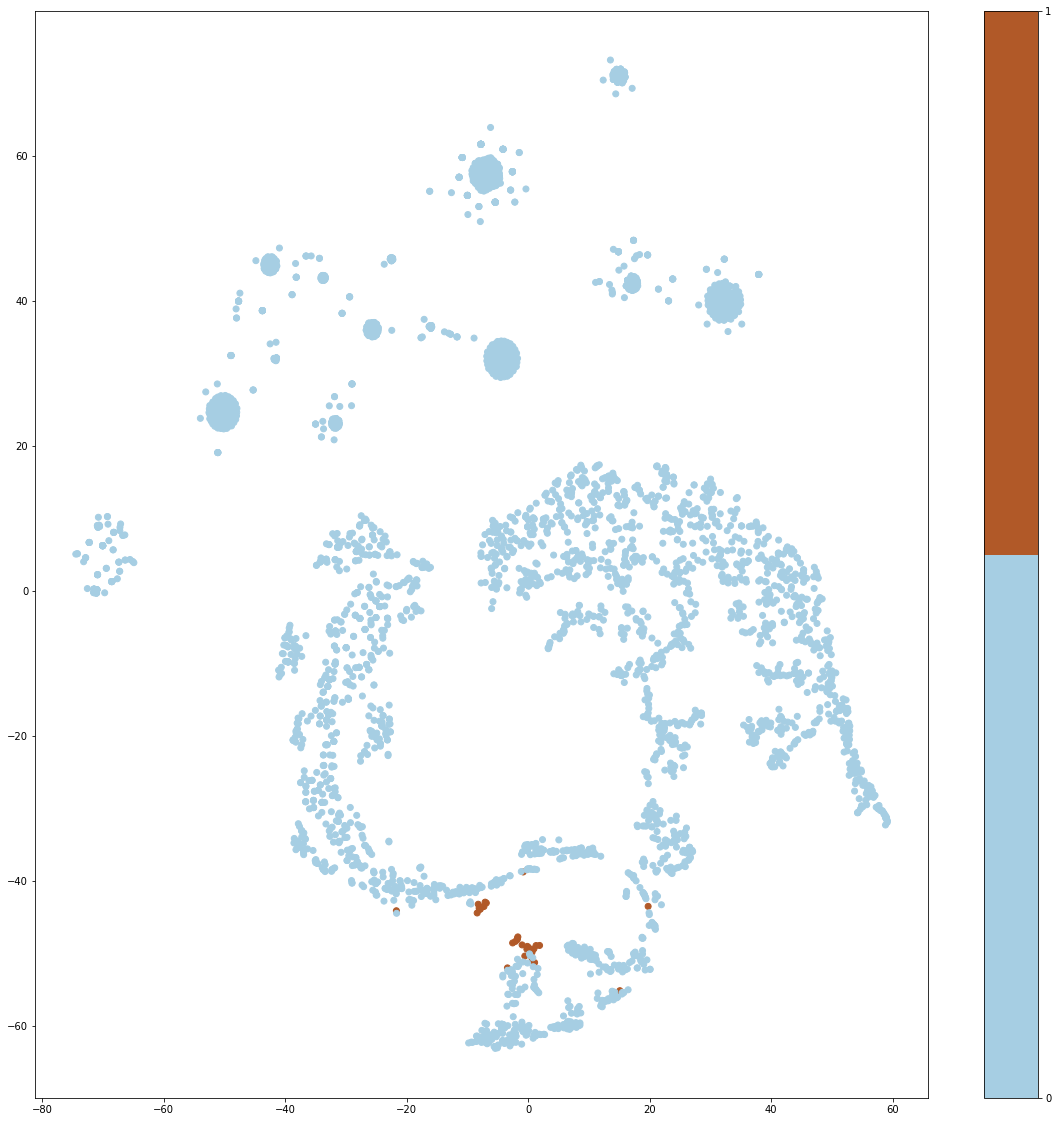

In [ ]:
#Без AMOUNT
plt.figure(figsize=(20,20))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y_plt, cmap=plt.cm.get_cmap("Paired", 2))
plt.colorbar(ticks=range(2))

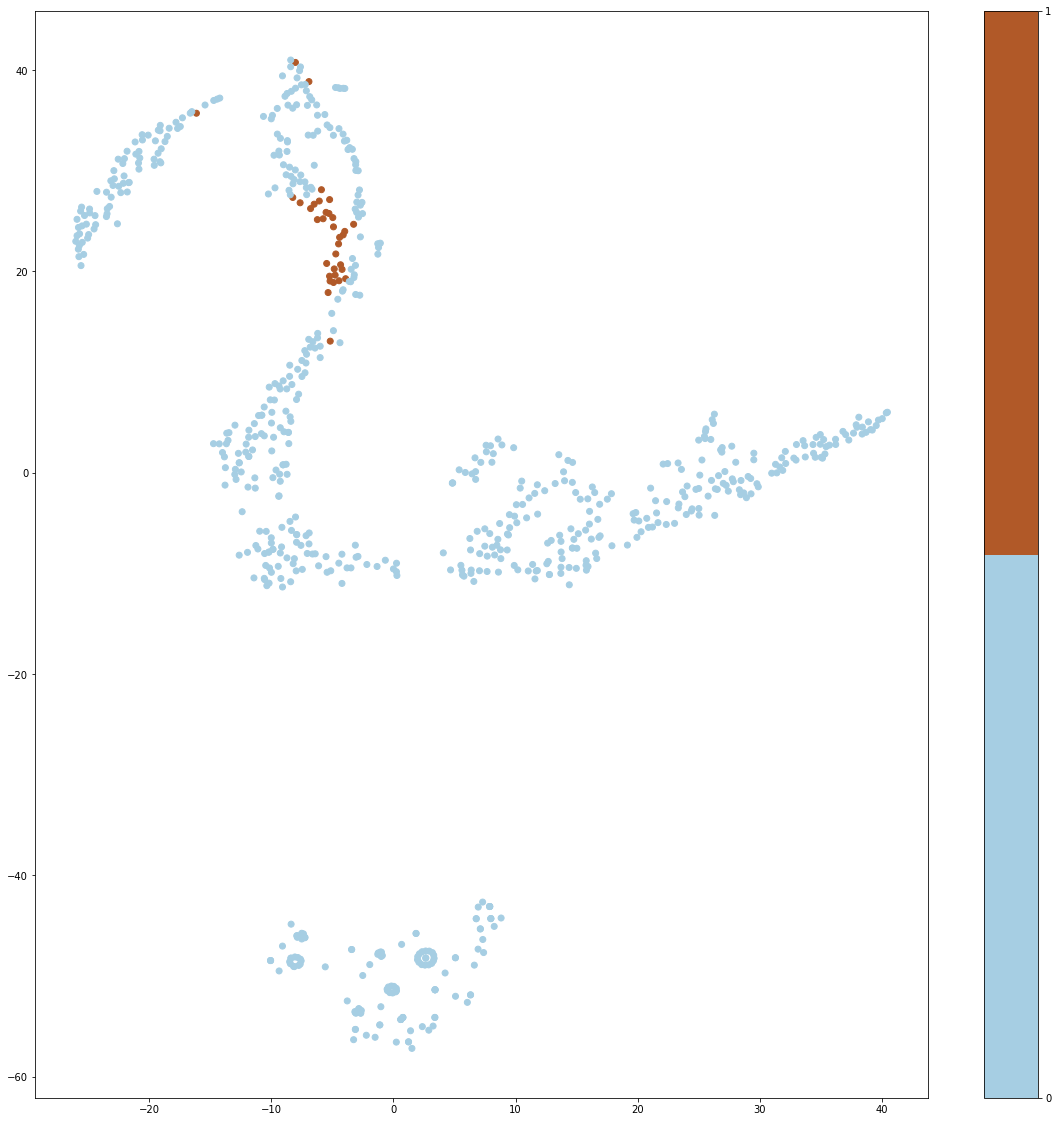

In [ ]:
#С AMOUNT
plt.figure(figsize=(20,20))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y_plt, cmap=plt.cm.get_cmap("Paired", 2))
plt.colorbar(ticks=range(2))

###9.2.1 List for drop

In [ ]:
drop_list_corr = ['TRANSACTION_ID', 'STATUS', 'TRANSACTION_TYPE', 'CURRENCY',\
            'START_TIME', 'A01_CREATED_AT', 'A02_CREATED_AT', 'C01_CREATED_AT', 'C02_CREATED_AT', 'C03_CREATED_AT',\
            'C04_CREATED_AT','C05_CREATED_AT', 'C06_CREATED_AT', 'C21_CREATED_AT', 'C23_CREATED_AT', 'C22_CREATED_AT',\
            'C24_CREATED_AT', 'C02_MSG_STATUS', 'AMOUNT', 'SENDER_BANK_ID', 'SENDER_USER_ID',	'SENDER_USER_PAM',\
            'RECEIVER_BANK_ID',	'RECEIVER_USER_ID',	'RECEIVER_USER_PAM', 'AMOUNT', 'A02_RESP_CODE' ]

### 9.2.2 Корреляция

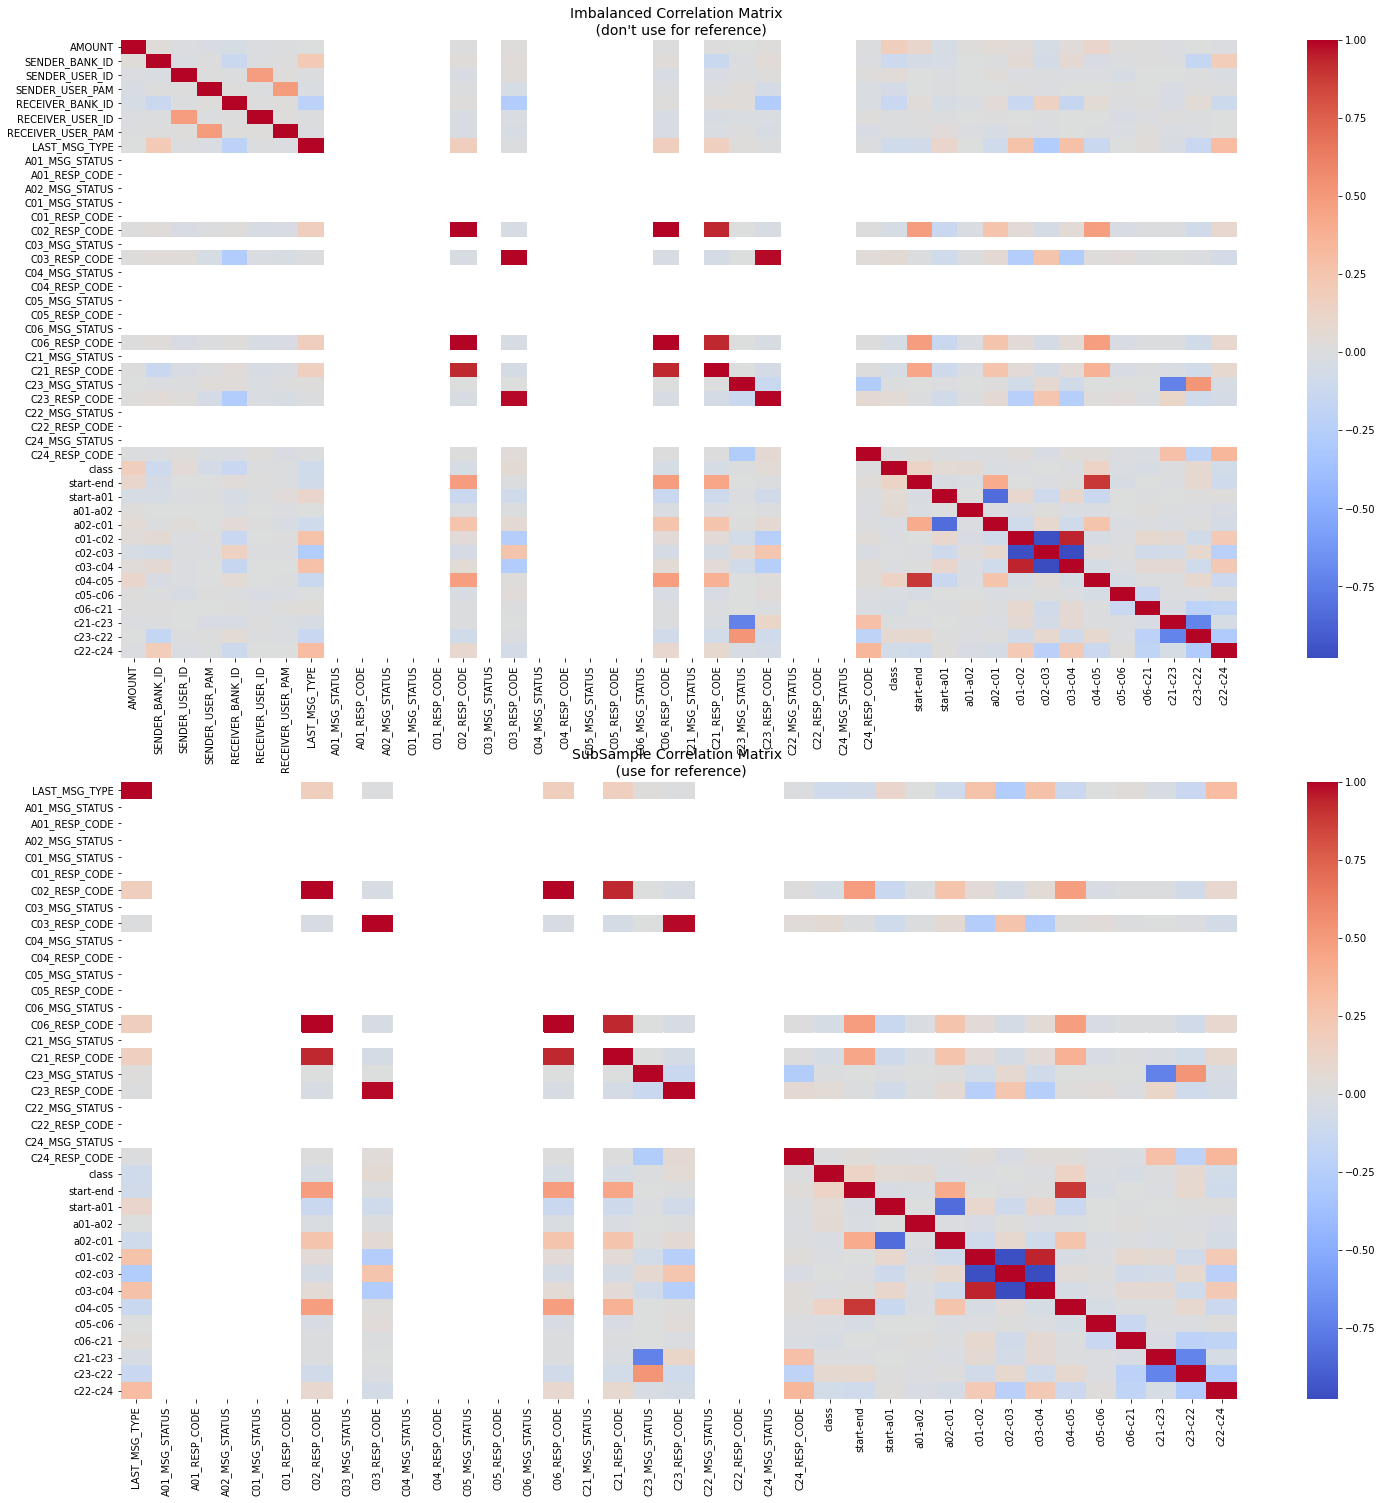

In [ ]:
# Корреляция на общем df
# Создаем полотно
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(25,25))

# Вводим даные
corr = disbal_distributed_df.corr() # разбалансированный датасет
sns.heatmap(corr, cmap='coolwarm', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

# Корелляция на удаленных признаках
sub_sample_corr = disbal_distributed_df.drop(drop_list_corr, axis = 1).corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

##9.3 Дополнительная визуализация статистики

###9.3.1 Зависимость размера суммы от времени транзакции 

1.  по оси X - сумма ранзакции, по оси y - время транзакции

In [ ]:
# распределение fraud по времени от размера транзакции
plt.figure(figsize=(8,4))
fig = plt.scatter(x=df[df['Class'] == 1]['Time'], y=df[df['Class'] == 1]['Amount'], color="c")
plt.title("Time vs Transaction Amount in Fraud Cases")
plt.show()

In [ ]:
# распределение нормальных транзакций по времени от размера транзакции
plt.figure(figsize=(8,4))
fig = plt.scatter(x=df[df['Class'] == 1]['Time'], y=df[df['Class'] == 1]['Amount'], color="c")
plt.title("Time vs Transaction Amount in Fraud Cases")
plt.show()

In [ ]:
# распределение нормальных транзакций по времени от размера транзакции
plt.figure(figsize=(8,4))
fig = plt.scatter(x=df[df['Class'] == 1]['Time'], y=df[df['Class'] == 1]['Amount'], color="c")
plt.title("Time vs Transaction Amount in Fraud Cases")
plt.show()

#10 ML

##10.1 Unsupervised

In [ ]:
print('hello')

hello


##10.2 Supervised

Распределение классов 
0    10.367647
1     0.500000
Name: class, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


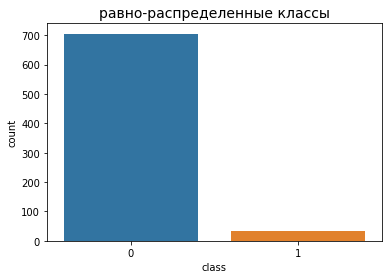

In [ ]:
print('Распределение классов ')
print(disbal_distributed_df.drop(drop_list_corr, axis = 1)['class'].value_counts()/len(new_df))
sns.countplot('class', data=disbal_distributed_df.drop(drop_list_corr, axis = 1))
plt.title('равно-распределенные классы', fontsize=14)
plt.show()

###10.2.1 Isolation Forest

In [ ]:
# Создаём df для анализа
df = disbal_distributed_df.drop(drop_list_corr, axis = 1)

In [ ]:
df = XY

In [ ]:
XY.shape

(63871, 38)

In [ ]:
# нормальные транзакции
normal = df[df['class']==0]
normal = normal.drop(['class'], axis=1)
# fraud 
fraud = df[df['class']==1]
fraud = fraud.drop(['class'], axis=1)

#Создание тестовой и обучающей выборки
normal_train, normal_test = train_test_split(normal, test_size=0.30, random_state=42)

In [ ]:
# Создаём модель изолирующего леса
model = IsolationForest()
model.fit(normal_train)
#Выполняем предикт на нормальных трангзакциях
normal_pred_test = model.predict(normal_test)
# выполняем предикт на fraud
fraud_pred = model.predict(fraud)

In [ ]:
print("Accuracy in Normal Cases:", list(normal_pred_test).count(1)/normal_pred_test.shape[0])
print("Accuracy in  Fraud Cases:", list(fraud_pred).count(-1)/fraud_pred.shape[0])

Accuracy in Normal Cases: 0.825
Accuracy in  Fraud Cases: 0.35294117647058826


Проверка только на временных фичах

In [ ]:
df = XY[['class','start-end',	'start-a01',	'a01-a02',	'a02-c01',\
                           'c01-c02',	'c02-c03',	'c03-c04',	'c04-c05',	'c05-c06',\
                           'c06-c21',	'c21-c23',	'c23-c22',	'c22-c24']]

In [ ]:
# Нормальные операции 
inliers_mask = df['class']==0
inliers = df[inliers_mask]
y_inliers = df[inliers_mask]['class']
X_inliers = inliers.drop(['class'], axis=1)


# Выбросы
outliers = df[df['class']==1]
outliers = outliers.drop(['class'], axis=1)

#Разделение выборки
inliers_train, inliers_test = train_test_split(X_inliers, test_size=0.30, random_state=42)
y_inliers_train, y_inliers_test = train_test_split(y_inliers, test_size=0.30, random_state=42)


# Изолирующий лес
isol = IsolationForest()
isol.fit(inliers_train)

# делаем предикт
# для нормальных операций
inlier_pred_test = isol.predict(inliers_test)
#для мошеннических операций
outlier_pred = isol.predict(outliers)

print("Accuracy in Legit Cases:", list(inlier_pred_test).count(1)/inlier_pred_test.shape[0])
print("Accuracy in Fraud Cases:", list(outlier_pred).count(-1)/outlier_pred.shape[0])

Accuracy in Legit Cases: 0.9286758563074352
Accuracy in Fraud Cases: 0.2647058823529412


In [ ]:
outliers = df[df['class']==1]
f = np.array(outliers['class'])

In [ ]:
inliers_mask = df['class']==0
y_inliers = df[inliers_mask]['class']
y_inliers_train, y_inliers_test = train_test_split(y_inliers, test_size=0.30, random_state=42)

In [ ]:
outliers = df[df['class']==1]
unsup_1y_true = np.array(outliers['class'])
type(unsup_1y_true)

numpy.ndarray

In [ ]:
outlier_pred

array([-1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1, -1, -1, -1,  1,
       -1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1, -1,  1, -1,  1])

In [ ]:
print(len(inlier_pred_test))
print(len(y_inliers_test))

1040
1040


In [ ]:
np.array(outliers['class'])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
# лист фродов
f = list(outliers['class'])
# лист нормальных
nf = list(y_inliers_test)
#склейка
full = f
full.extend(nf)
print(len(full))

# для фродов
frad_pred_list =[]
for i in outlier_pred:
  if i == -1:
    i = 0
  frad_pred_list.append(i)
print(frad_pred_list)
print(len(frad_pred_list))

# для нормальных
norm_pred_list =[]
for i in inlier_pred_test:
  if i == 1:
    i = 0
  elif i == -1:
    i = 1
  norm_pred_list.append(i)
print(norm_pred_list)
print(len(norm_pred_list))


#склейка predict
full_pred = frad_pred_list

full_pred.extend(norm_pred_list)
print(len(full_pred))
print(len(full))
full_pred = list(full_pred)
full = list(full)

19186
[1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
34
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,

In [ ]:
frad_pred_list + norm_pred_list = 1074

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(full, full_pred)

array([[17786,  1366],
       [    9,    25]])

Accuracy:  0.9283331595955384
Recall:  0.9283331595955384
Precision:  0.017972681524083392
F1:  0.03508771929824561
Roc_AUC:  0.831984986977247
Confusion Matrix: 
       0     1
0  17786  1366
1      9    25


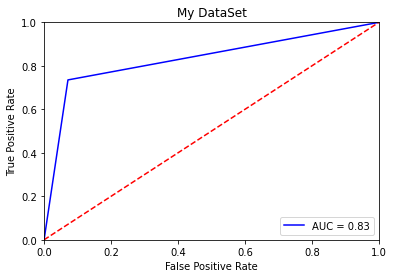

In [ ]:
value_of_metrics(full, full_pred)

In [ ]:
#UNSUPERVISED

# FAR = FPR = FP/(FP + TN)
# вероятность пропуска fraud
far = 9/(9+17786)
print('Вероятность пропуска fraud - FAR = ', far)

# FRR = FNR = FN/(FN + TP)
# вероятность блокировки нормальной транзакции
frr = 1366/(1366+25)
print('Вероятность блокировки нормальной транзакции - FRR = ', frr)

Вероятность пропуска fraud - FAR =  0.0005057600449564485
Вероятность блокировки нормальной транзакции - FRR =  0.9820273184759166


In [ ]:
#UNSUPERVISED

# FAR = FPR = FP/(FP + TN)
# вероятность пропуска fraud
far = 9/(9+25)
print('Вероятность пропуска fraud - FAR = ', far)

# FRR = FNR = FN/(FN + TP)
# вероятность блокировки нормальной транзакции
frr = 1366/(1366+17786)
print('Вероятность блокировки нормальной транзакции - FRR = ', frr)

Вероятность пропуска fraud - FAR =  0.2647058823529412
Вероятность блокировки нормальной транзакции - FRR =  0.07132414369256475


In [ ]:
54655+10345

65000

###10.2.2 Random forest

In [ ]:
XY.info()

In [ ]:
df_rf = disbal_distributed_df.drop(drop_list_corr, axis =1)
#df_rf = df_upsampled.drop('A02_RESP_CODE', axis=1)
#df_rf = df
X = df_rf.drop(['class',], axis =1)
y = df_rf['class']

In [ ]:
df_rf['class'].value_counts()

0    63837
1       34
Name: class, dtype: int64

In [ ]:
# Разделение на обучающую (75%) и тестовую (25%) выборку 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99, random_state=42, shuffle=True)

In [ ]:
#создаём и обучаем классификатор
model_RF = RandomForestClassifier(n_estimators=10).fit(X_df_up, y_df_up)
# делаем предсказание
model_RF_pred = model_RF.predict(X_test)

In [ ]:
y_test.value_counts()

0    57453
1       31
Name: class, dtype: int64

Accuracy:  1.0
Recall:  1.0
Precision:  1.0
F1:  1.0
Roc_AUC:  1.0
Confusion Matrix: 
       0   1
0  63199   0
1      0  34


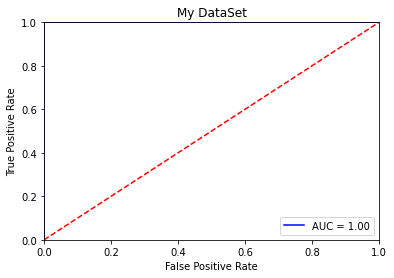

In [ ]:
#SUPERVISED

# Смотрим предсказание классификатора
predictions_rf = pd.DataFrame(model_RF_pred)
predictions_rf[0].value_counts()

#confusion matrix and ROC AUC
value_of_metrics(y_test, model_RF_pred)

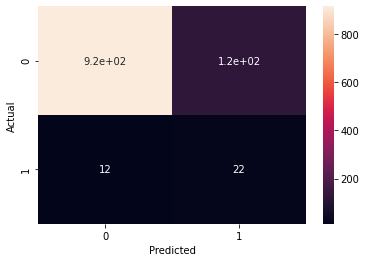

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

data = {'y_Actual':    full,
        'y_Predicted': full_pred
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
# FAR = FPR = FP/(FP + TN)
# вероятность пропуска fraud
far = 9/(9+1036)
print('Вероятность пропуска fraud - FAR = ', far)

# FRR = FNR = FN/(FN + TP)
# вероятность блокировки нормальной транзакции
frr = 0/(0+4)
print('Вероятность блокировки нормальной транзакции - FRR = ', frr)

Вероятность пропуска fraud - FAR =  0.00861244019138756
Вероятность блокировки нормальной транзакции - FRR =  0.0


In [ ]:
#SUPERVISED

# FAR = FPR = FP/(FP + TN)
# вероятность пропуска fraud
far = 0/(0+34)
print('Вероятность пропуска fraud - FAR = ', far)

# FRR = FNR = FN/(FN + TP)
# вероятность блокировки нормальной транзакции
frr = 0/(0+63199)
print('Вероятность блокировки нормальной транзакции - FRR = ', frr)

Вероятность пропуска fraud - FAR =  0.0
Вероятность блокировки нормальной транзакции - FRR =  0.0


In [ ]:
34*0.444

15.096

In [ ]:
far = 9/(9+1036)
far

0.00861244019138756

In [ ]:
frr = 1/(1+4)
frr

0.2

In [ ]:
tnr = recall_score(y_test, model_RF_pred, pos_label = 1)
tnr

0.3076923076923077

-----------------


#Workflow expand


In [ ]:
import pickle
# Сохраним модель на базе только временных фичей
filename = '30102020_RandomForest_99_v001.sav'
pickle.dump(model_RF_pred, open(filename, 'wb'))

In [ ]:
model_RF_pred

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(normal_train)
result

In [ ]:
disbal_distributed_df.head()

In [ ]:
df_withtf.head()

In [ ]:
disbal_distributed_df.to_csv('30102020_nspk_disbalDF.csv', sep = ';', encoding = 'utf-8', index=False)
df_withtf.to_csv('30102020_nspk_balancedDF.csv', sep = ';', encoding ='utf-8', index=False)

In [ ]:
disbal_distributed_df = pd.read_csv('30102020_nspk_disbalDF.csv', sep = ';', encoding = 'utf-8')
df_withtf = pd.read_csv('30102020_nspk_balancedDF.csv', sep = ';', encoding = 'utf-8')

In [ ]:
df_rf.to_csv('11112020_disbal64K.csv', sep = ';', encoding ='utf-8', index=False)

In [ ]:
disbal_distributed_df = pd.read_csv('30102020_nspk_balancedDF.csv', sep = ';', encoding = 'utf-8')

In [ ]:
#количество классов в тестовой выборке
y_test.value_counts()

In [ ]:
df_withtf.shape

(68, 63)

In [ ]:
from sklearn.utils import resample

In [ ]:
# объединяем X_train, y_train
XY = df_rf
#расширяем датасет (мажоритарные данные)
area_0 = XY[XY['class']==0]
area_1 = XY[XY['class']==1]

area_upsampled = resample(area_1,
                          replace=True,
                          n_samples=len(area_0), 
                          random_state=42)


df_upsampled = pd.concat([area_0, area_upsampled])

print(df_upsampled['class'].value_counts())

y_df_up = df_upsampled['class']
X_df_up = df_upsampled.drop('class', axis=1)

1    63837
0    63837
Name: class, dtype: int64
